**1. Предобработка данных**

На первом этапе происходит выбор признаков и целевой переменной. Из исходного датасета weather_data выделяются признаки (все столбцы, кроме 'Weather Type') в переменную X, а целевая переменная ('Weather Type') сохраняется в переменную y.

Следующим шагом является кодирование целевой переменной с использованием LabelEncoder. Целевая переменная y преобразуется в числовой формат, где каждый уникальный класс погоды получает своё числовое значение. Это необходимо для большинства алгоритмов машинного обучения, которые работают с числовыми данными. Классы сохраняются в переменной class_names.

Далее происходит определение типов признаков. Признаки делятся на числовые (numeric_features) и категориальные (categorical_features). Числовые признаки включают такие параметры, как температура, влажность, скорость ветра и другие, а категориальные — облачность, сезон и местоположение.

Для визуализации распределения классов строится столбчатая диаграмма, показывающая количество записей для каждого типа погоды. Это позволяет оценить балансировку классов в данных.

Следующим шагом вычисляются статистические характеристики числовых признаков: среднее, медиана, мода, асимметрия и эксцесс. Эти показатели помогают оценить характеристики на наличие нормального распределения.

Категориальные переменные кодируются с использованием LabelEncoder. Каждый уникальный уровень категориального признака получает своё числовое значение. Это необходимо для алгоритмов, которые не могут работать с текстовыми данными напрямую.

Далее данные делятся на обучающую и тестовую выборки с использованием функции train_test_split. Это позволяет оценить качество модели на данных, которые она не видела во время обучения.

Наконец, создаётся объект ColumnTransformer для предобработки данных. Числовые признаки масштабируются с использованием MinMaxScaler, который приводит значения к диапазону от 0 до 1. Категориальные признаки кодируются с использованием OneHotEncoder, который преобразует категориальные переменные в бинарные столбцы. Параметр drop='first' позволяет избежать мультиколлинеарности, удаляя первый столбец из закодированных категориальных переменных.

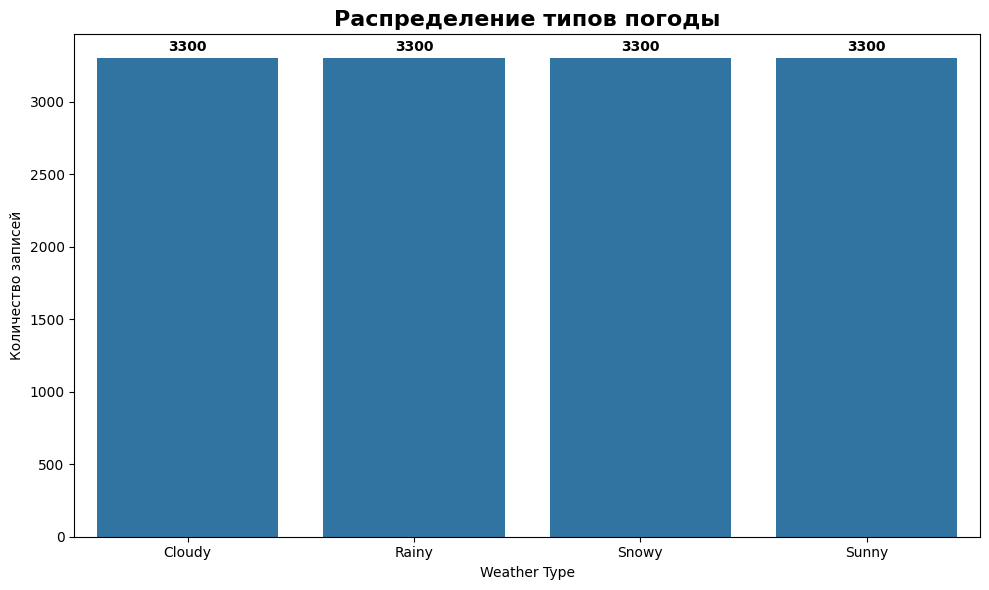

Статистические характеристики:
                           Среднее  Медиана     Мода  Ассиметрия   Эксцесса
Temperature             19.127576    21.00    32.00    0.221716   0.585374
Humidity                68.710833    70.00    76.00   -0.401569  -0.338692
Wind Speed               9.832197     9.00     8.00    1.360108   3.253506
Precipitation (%)       53.644394    58.00    19.00   -0.152440  -1.353980
Atmospheric Pressure  1005.827896  1007.65  1013.57   -0.293865  12.772776
UV Index                 4.005758     3.00     1.00    0.899908  -0.362483
Visibility (km)          5.462917     5.00     1.50    1.233135   2.515867


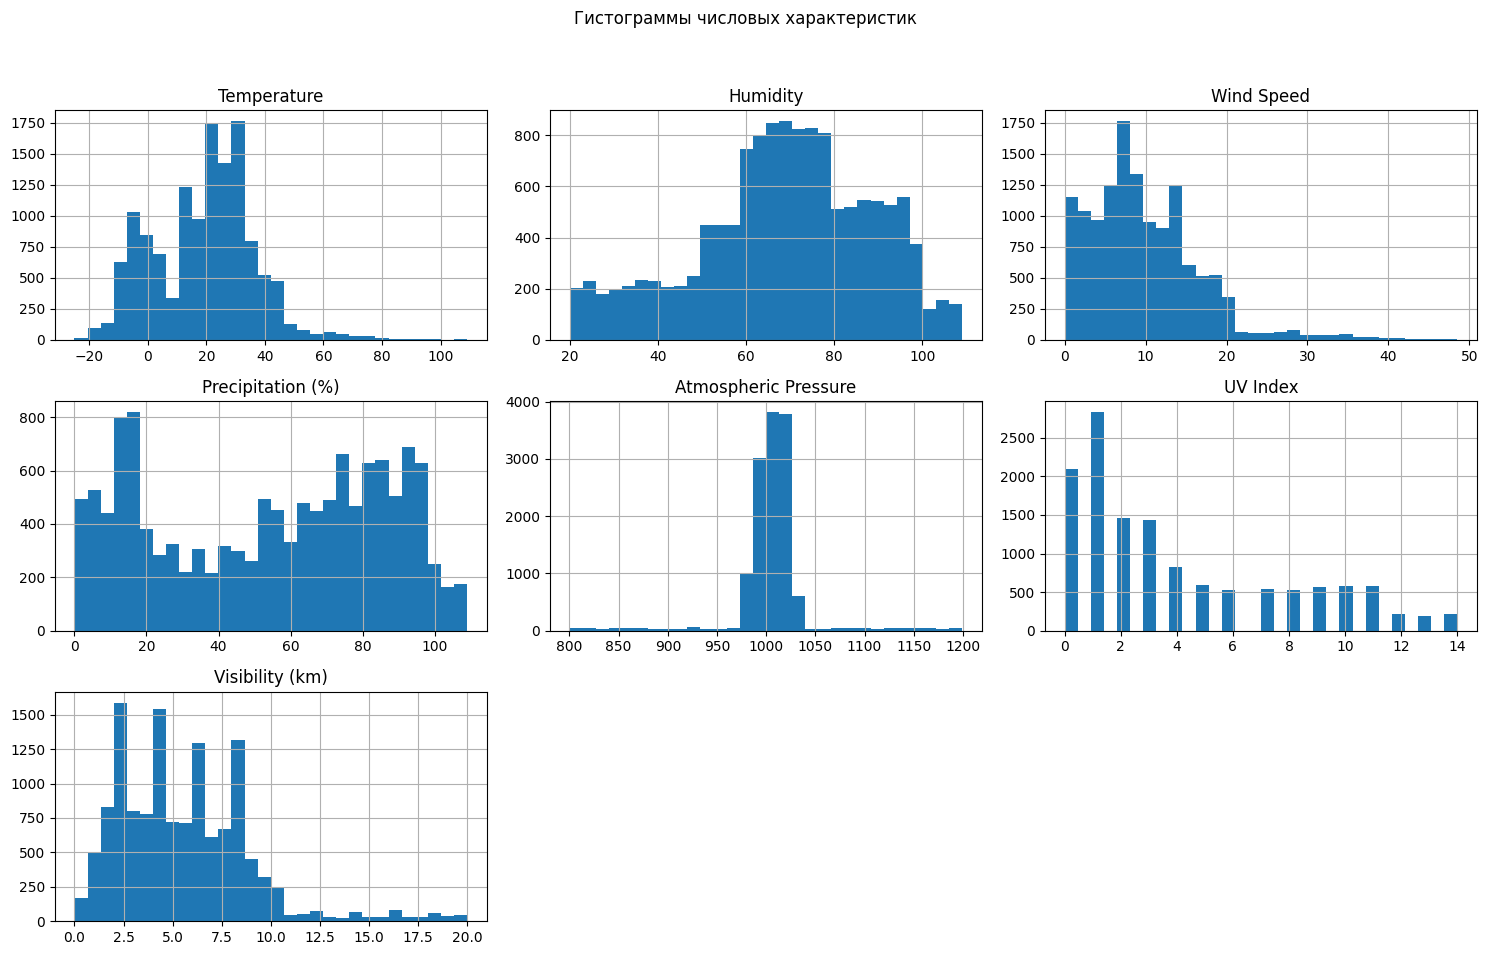

In [6]:
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler, label_binarize, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import GaussianNB, MultinomialNB, ComplementNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt

def calculate_metrics(y_true, y_pred, y_proba, dataset_name):
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    roc_auc = roc_auc_score(y_true, y_proba, multi_class='ovr')
    print(f"Метрики для {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC AUC: {roc_auc:.4f}")
    print('\n')

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'ROC AUC': roc_auc}

# Загрузка данных
weather_data = pd.read_csv('C:\\Users\\Egor\\Documents\\ML\\Lab3\\weather_classification_data.csv')

# Выбор признаков и целевой переменной
X = weather_data.drop(columns=['Weather Type'])
y = weather_data['Weather Type']

# Кодирование целевой переменной
le = LabelEncoder()
y_encoded = le.fit_transform(y)
class_names = le.classes_

# Определение типов признаков
numeric_features = ['Temperature', 'Humidity', 'Wind Speed', 'Precipitation (%)',
                    'Atmospheric Pressure', 'UV Index', 'Visibility (km)']
categorical_features = ['Cloud Cover', 'Season', 'Location']

numeric_columns = weather_data.select_dtypes(include=[np.number]).columns

#Распределение классов
plt.figure(figsize=(10, 6))
sns.countplot(data=weather_data, x='Weather Type', order=class_names)
plt.title('Распределение типов погоды', fontsize=16, fontweight='bold')
plt.ylabel('Количество записей')
plt.xticks(rotation=0)
for i, v in enumerate(weather_data['Weather Type'].value_counts().sort_index()):
    plt.text(i, v + 50, str(v), ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

stats = pd.DataFrame({
    'Среднее': weather_data[numeric_columns].mean(),
    'Медиана': weather_data[numeric_columns].median(),
    'Мода': weather_data[numeric_columns].mode().iloc[0],
    'Ассиметрия': weather_data[numeric_columns].apply(skew),
    'Эксцесса': weather_data[numeric_columns].apply(kurtosis)
})

print("Статистические характеристики:\n", stats)

# Построение гистограмм
weather_data[numeric_columns].hist(bins=30, figsize=(15, 10), layout=(-1, 3))
plt.suptitle('Гистограммы числовых характеристик')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

# Кодирование категориальных переменных
categorical_cols_weather = ['Cloud Cover', 'Season', 'Location']
label_encoders_weather = {col: LabelEncoder() for col in categorical_cols_weather}

for col in categorical_cols_weather:
    X[col] = label_encoders_weather[col].fit_transform(X[col])

# Разделение данных на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numeric_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features)
    ])


Temperature - среднее, медиана и мода не равны => характеристика не обладает нормальным распределением

Humidity - среднее, медиана и мода не равны, но близки, ассиметрия и эксцесса примерно равны нулю => характеристика близка к нормальному распределению

Wind Speed - среднее, медиана и мода не равны, но близки, ассиметрия и эксцесса не равны нулю => характеристика не обладает нормальным распределением

Precipitation (%) - среднее, медиана и мода не равны => характеристика не обладает нормальным распределением

Atmospheric Pressure - среднее, медиана и мода не равны, но близки, ассиметрия и эксцесса не равны нулю => характеристика не обладает нормальным распределением

UV Index - среднее, медиана и мода не равны => характеристика не обладает нормальным распределением

Visibility (km) - среднее, медиана и мода не равны => характеристика не обладает нормальным распределением

**Наивный Байесовский классификатор**

В машинном обучении Наивный Байесовский классификатор - семейство простых вероятностных классификаторов, основанных на использовании теоремы Байеса и «наивном» предположении о независимости признаков классифицируемых объектов. Как и любой классификатор, байесовский присваивает метки классов наблюдениям, представленным векторами признаков. При этом предполагается, что каждый признак независимо влияет на вероятность принадлежности наблюдения к классу. Простой байесовский классификатор строится на основе обучения с учителем. Несмотря на малореалистичное предположение о независимости признаков, простые байесовские классификаторы хорошо зарекомендовали себя при решении многих практических задач. Дополнительным преимуществом метода является небольшое число примеров, необходимых для обучения. 

По сути, байесовский классификатор представляет собой вероятностную модель. Пусть задано множество наблюдений, каждое из которых представлено вектором признаков x = (x1,x2, ..., xn). Модель присваивает каждому наблюдению условную вероятность p(Ck|x1,x2, ..., xn), Ck — класс.

Используя теорему Байеса, можно записать:
<br>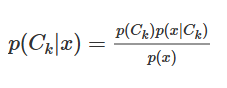
<br>В этой формуле интерес с точки зрения классификации представляет только числитель, поскольку знаменатель от метки классов не зависит и является константой. При условии, что признаки независимы, можно показать, что
<br>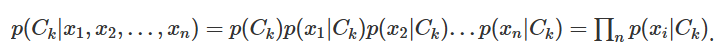
<br>Тогда простой байесовский классификатор можно рассматривать как функцию, которая каждому выходному значению модели присваивает метку класса, т.е. y = Ck следующим образом:
<br>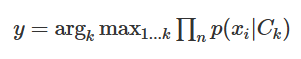
<br>Таким образом, выбирается класс Ck, который максимизирует функцию правдоподобия, представляющую собой произведение условных вероятностей значений признака xi по каждому классу Ck.

Вероятностный классификатор предсказывает класс с самой большой условной вероятностью для заданного вектора признаков x.

Наивный Байесовский классификатор
Метрики для GaussianNB:
Accuracy: 0.8367
Precision: 0.8379
Recall: 0.8367
F1-Score: 0.8351
ROC AUC: 0.9446


Метрики для MultinomialNB:
Accuracy: 0.7053
Precision: 0.6947
Recall: 0.7053
F1-Score: 0.6926
ROC AUC: 0.8938


Метрики для ComplementNB:
Accuracy: 0.6394
Precision: 0.6440
Recall: 0.6394
F1-Score: 0.6150
ROC AUC: 0.8680


Метрики для BernoulliNB:
Accuracy: 0.6443
Precision: 0.6658
Recall: 0.6443
F1-Score: 0.6452
ROC AUC: 0.8373




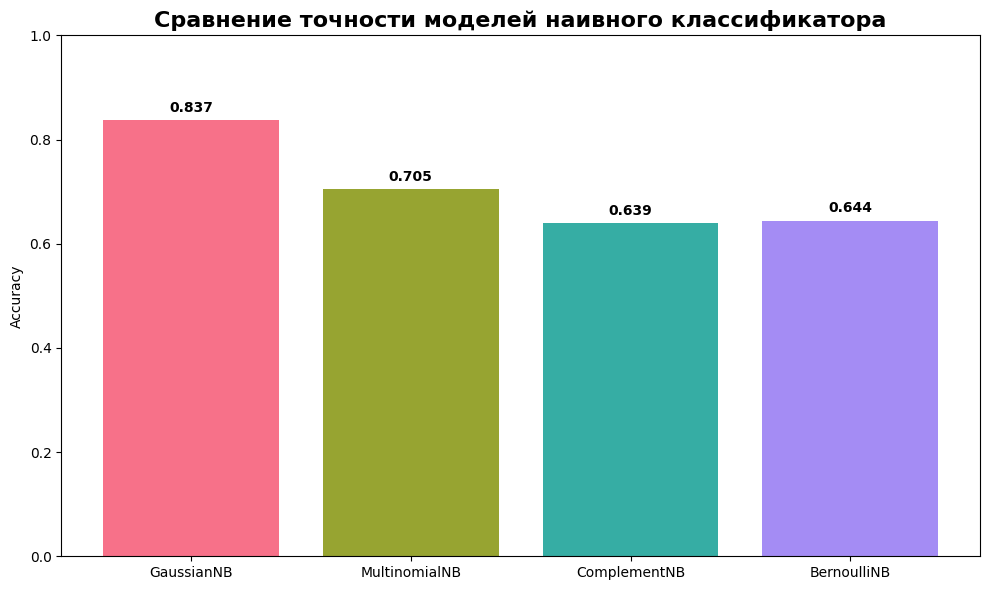

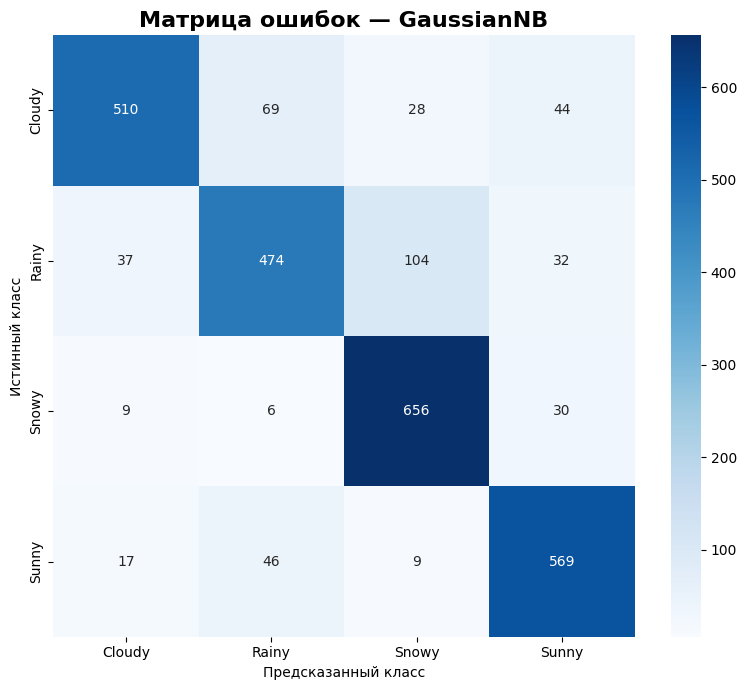

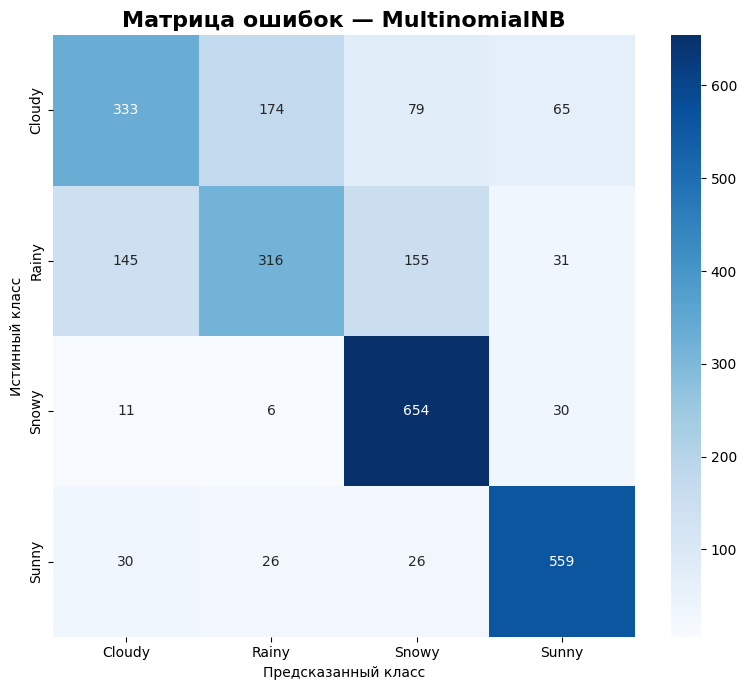

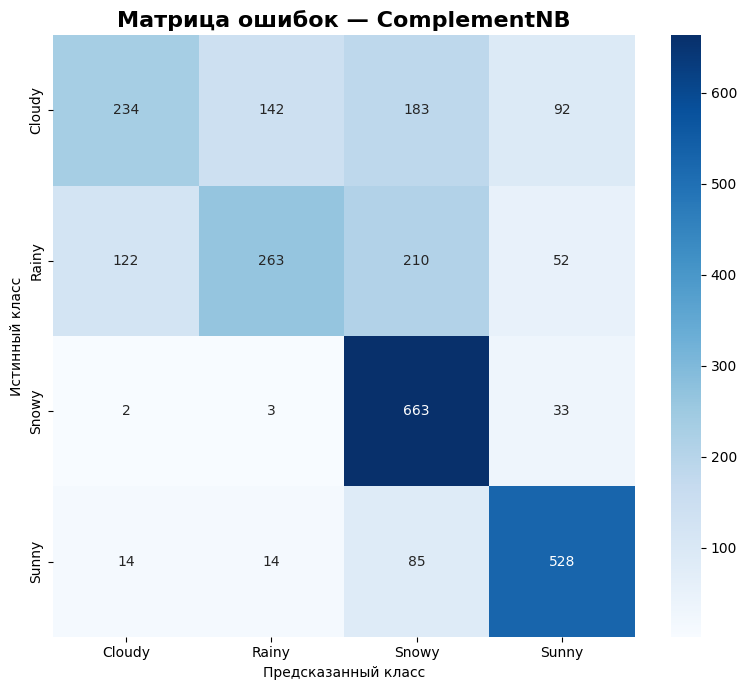

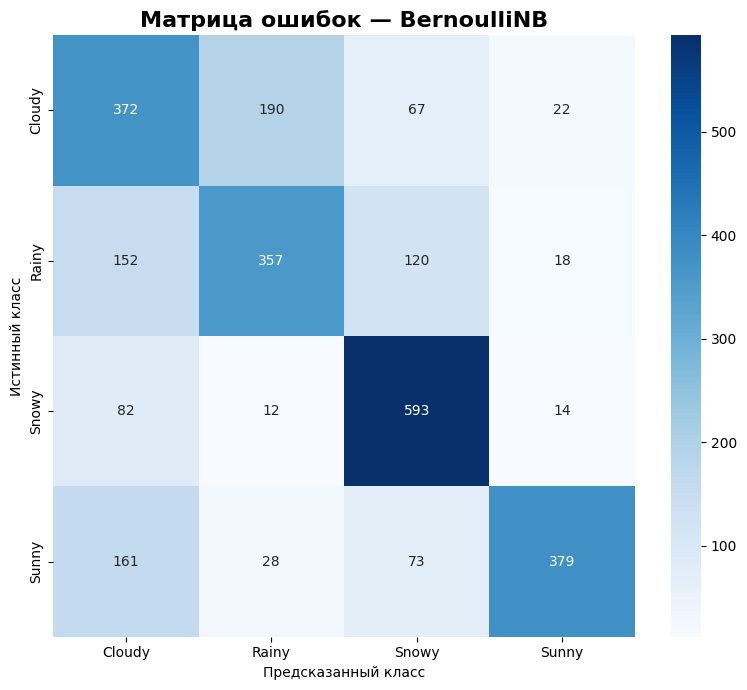

Отчет о классификации
              precision    recall  f1-score   support

      Cloudy      0.890     0.783     0.833       651
       Rainy      0.797     0.733     0.763       647
       Snowy      0.823     0.936     0.876       701
       Sunny      0.843     0.888     0.865       641

    accuracy                          0.837      2640
   macro avg      0.838     0.835     0.834      2640
weighted avg      0.838     0.837     0.835      2640



In [7]:

models = {
    'GaussianNB': GaussianNB(),
    'MultinomialNB': MultinomialNB(),
    'ComplementNB': ComplementNB(),
    'BernoulliNB': BernoulliNB()
}

results = {}
predictions = {}
probs = {}

print("Наивный Байесовский классификатор")

for name, model in models.items():
    try:
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model)
        ])
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        y_proba = pipeline.predict_proba(X_test)

        metrics = calculate_metrics(y_test, y_pred, y_proba, name)

        results[name] = metrics['Accuracy']
        predictions[name] = y_pred
        probs[name] = y_proba

    except Exception as e:
        print(f"{name} — Ошибка: {str(e)}")
        results[name] = 0
        predictions[name] = None
        probs[name] = None

# Сравнение точности моделей
valid_models = {k: v for k, v in results.items() if v > 0}
plt.figure(figsize=(10, 6))
bars = plt.bar(valid_models.keys(), valid_models.values(), color=sns.color_palette("husl", len(valid_models)))
plt.title('Сравнение точности моделей наивного классификатора', fontsize=16, fontweight='bold')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.01,
             f'{height:.3f}', ha='center', va='bottom', fontweight='bold')
plt.tight_layout()
plt.show()

# Маьрица ошибок для лучшей модели
best_model_name = max(valid_models, key=valid_models.get)
y_pred_best = predictions[best_model_name]
plt.figure(figsize=(8, 7))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Матрица ошибок — {best_model_name}', fontsize=16, fontweight='bold')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

y_pred_m = predictions["MultinomialNB"]
plt.figure(figsize=(8, 7))
cm = confusion_matrix(y_test, y_pred_m)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Матрица ошибок — {"MultinomialNB"}', fontsize=16, fontweight='bold')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

y_pred_c = predictions['ComplementNB']
plt.figure(figsize=(8, 7))
cm = confusion_matrix(y_test, y_pred_c)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Матрица ошибок — {'ComplementNB'}', fontsize=16, fontweight='bold')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

y_pred_b = predictions['BernoulliNB']
plt.figure(figsize=(8, 7))
cm = confusion_matrix(y_test, y_pred_b)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title(f'Матрица ошибок — {'BernoulliNB'}', fontsize=16, fontweight='bold')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

# Classification Report
print("Отчет о классификации")
report = classification_report(y_test, y_pred_best, target_names=class_names,digits=3)
print(report)


Итоги

Модель - Точность

AccuracyGaussianNB - 0.823

MultinomialNB - 0.679

ComplementNB - 0.622

BernoulliNB - 0.67

Лучшая модель: GaussianNB (Accuracy: 0.823)
По матрицам ошибок остальных моделей видно, что их основная проблема - определение дождливой и облачной погоды. Это может быть связано с тем, что оба типа погоды имеют похожие признаки.

**Дерево решений**

Дерево решений — метод представления решающих правил в определенной иерархии, включающей в себя элементы двух типов — узлов (node) и листьев (leaf). Узлы включают в себя решающие правила и производят проверку примеров на соответствие выбранного атрибута обучающего множества.

Простой случай: примеры попадают в узел, проходят проверку и разбиваются на два подмножества:
первое — те, которые удовлетворяют установленное правило;
второе — те, которые не удовлетворяют установленное правило.
Далее к каждому подмножеству снова применяется правило, процедура повторяется. Это продолжается, пока не будет достигнуто условие остановки алгоритма. Последний узел, когда не осуществляется проверка и разбиение, становится листом.
Лист определяет решение для каждого попавшего в него примера. В листе содержится не правило, а подмножество объектов, удовлетворяющих всем правилам ветви, которая заканчивается этим листом. Пример попадает в лист, если соответствует всем правилам на пути к нему. К каждому листу есть только один путь.


Индекс Gini
Индекс Джини измеряет степень неоднородности узла. Он рассчитывает вероятность того, что случайно выбранная метка будет неправильно классифицирована, если бы она была помечена в соответствии с распределением меток в узле.
Формула:
<br>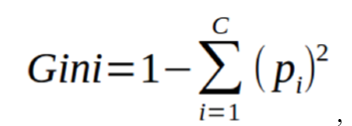
<br>где pi — вероятность наличия класса i в узле.

Fitting 5 folds for each of 72 candidates, totalling 360 fits
Лучшие параметры: {'classifier__criterion': 'gini', 'classifier__max_depth': 10, 'classifier__min_samples_leaf': 4, 'classifier__min_samples_split': 2}
Лучшая точность (CV): 0.9103

Точность на тесте: 0.9064
Отчет о классификации
              precision    recall  f1-score   support

      Cloudy      0.883     0.891     0.887       651
       Rainy      0.887     0.893     0.890       647
       Snowy      0.933     0.947     0.940       701
       Sunny      0.922     0.891     0.906       641

    accuracy                          0.906      2640
   macro avg      0.906     0.906     0.906      2640
weighted avg      0.907     0.906     0.906      2640

Метрики для Дерева решений:
Accuracy: 0.9064
Precision: 0.9066
Recall: 0.9064
F1-Score: 0.9064
ROC AUC: 0.9653




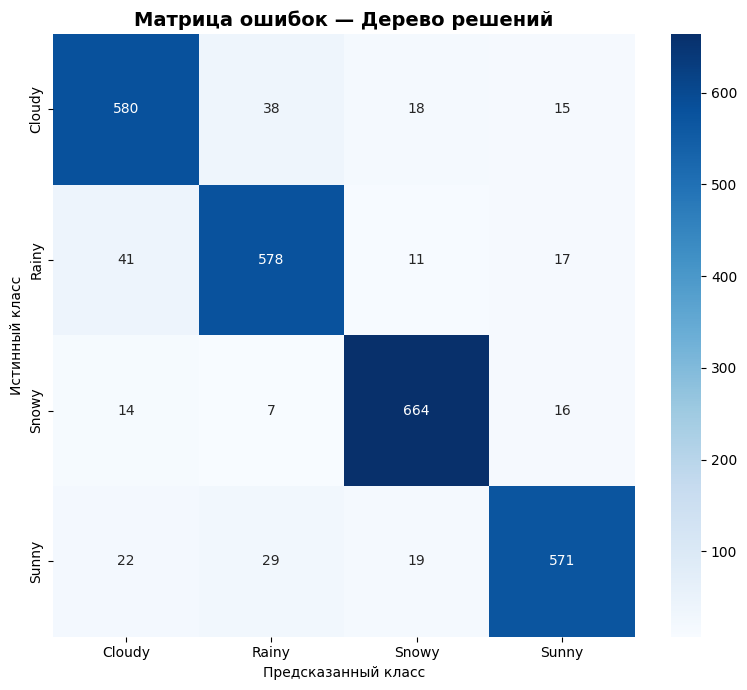

C:\Users\Egor\AppData\Local\Temp\ipykernel_17912\46771889.py:59: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')


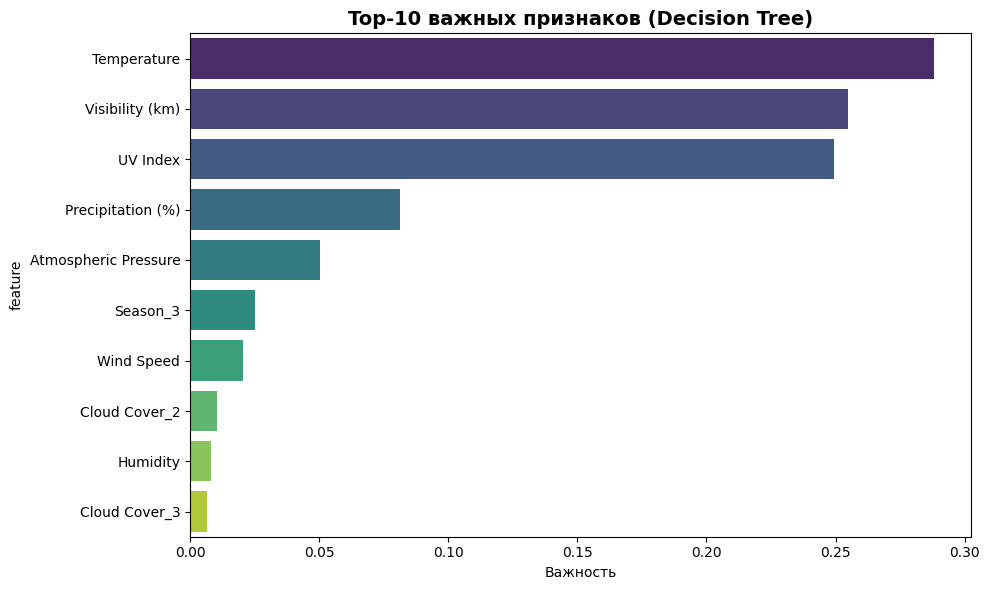

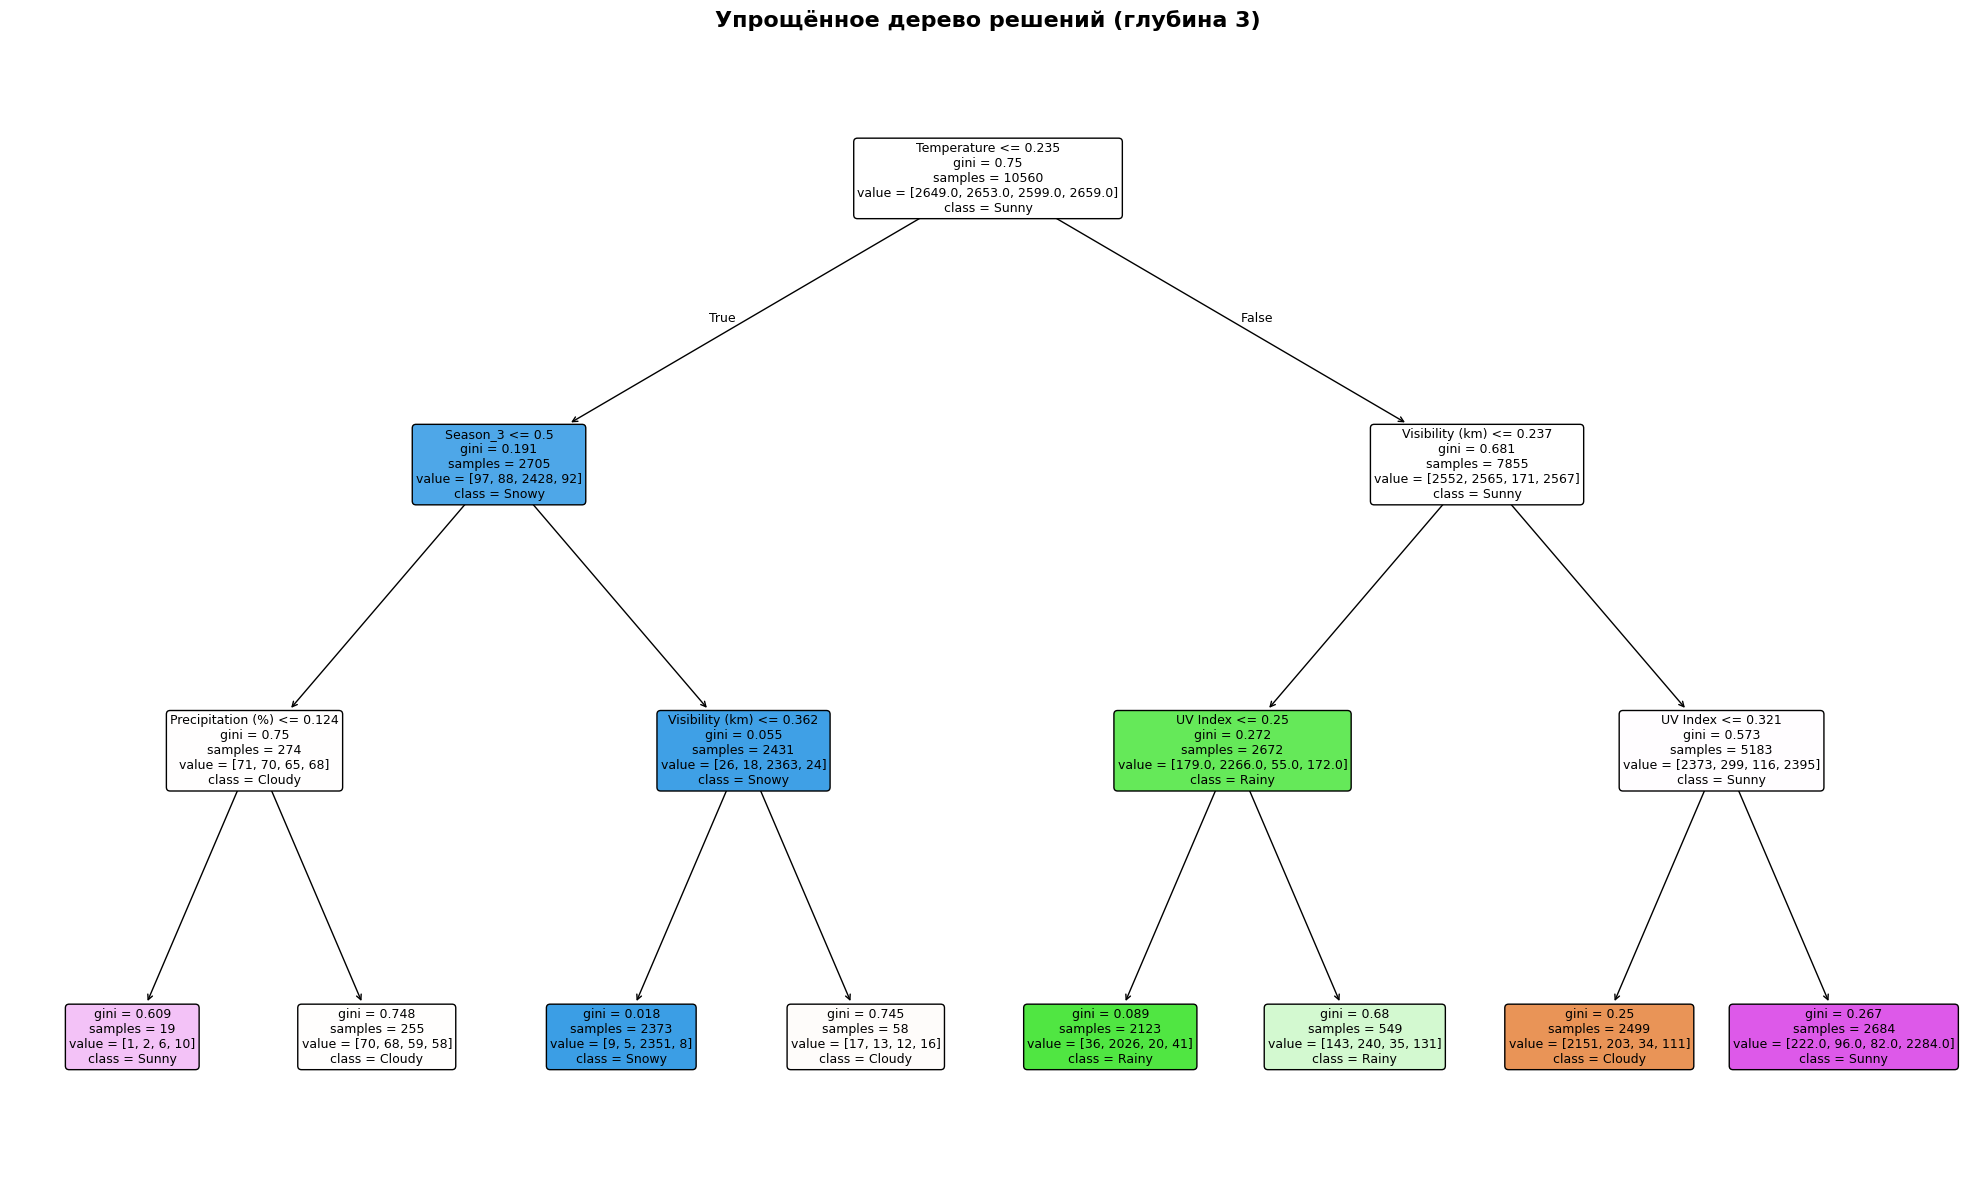

In [8]:
param_grid = {
    'classifier__max_depth': [5, 10, 15, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__criterion': ['gini', 'entropy']
}

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(random_state=42))
])

grid_search = GridSearchCV(
    pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1
)
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая точность (CV): {grid_search.best_score_:.4f}")

# Оценка на тестовой выборке
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"\nТочность на тесте: {accuracy:.4f}")

# Отчет о классификации
print("Отчет о классификации")
report = classification_report(y_test, y_pred, target_names=class_names, digits=3)
print(report)
calculate_metrics(y_test, y_pred, y_proba, "Дерева решений")

# Матрица ошибок
plt.figure(figsize=(8, 7))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок — Дерево решений', fontweight='bold', fontsize=14)
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()

feature_names = (
    numeric_features +
    best_model.named_steps['preprocessor']
    .named_transformers_['cat']
    .get_feature_names_out(categorical_features).tolist()
)

importances = best_model.named_steps['classifier'].feature_importances_
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(data=importance_df, x='importance', y='feature', palette='viridis')
plt.title('Top-10 важных признаков (Decision Tree)', fontweight='bold', fontsize=14)
plt.xlabel('Важность')
plt.tight_layout()
plt.show()

# Дерево
plt.figure(figsize=(20, 12))

# Безопасное извлечение параметров
best_params = {}
for k, v in grid_search.best_params_.items():
    if k.startswith('classifier__'):
        param_name = k.split('__')[1]
        best_params[param_name] = v

# Принудительно ограничиваем глубину для визуализации
best_params['max_depth'] = 3
best_params['random_state'] = 42

simplified_tree = DecisionTreeClassifier(**best_params)

simplified_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', simplified_tree)
])
simplified_pipeline.fit(X_train, y_train)

# Имена признаков
ohe = best_model.named_steps['preprocessor'].named_transformers_['cat']
cat_features = ohe.get_feature_names_out(categorical_features)
feature_names = numeric_features + cat_features.tolist()

plot_tree(
    simplified_pipeline.named_steps['classifier'],
    feature_names=feature_names,
    class_names=class_names,
    filled=True, rounded=True, fontsize=9
)
plt.title('Упрощённое дерево решений (глубина 3)', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


Главным фактором классификации выступает температура: при низких значениях модель почти всегда относит наблюдение к снежной или облачной погоде, при высоких — к солнечной или дождливой. Это разделение логично отражает реальную связь между температурой и погодой. В холодной ветви дерева ключевым дополнительным признаком оказывается сезон: если признак Season_3 указывает на зимний период, вероятность снежной погоды резко возрастает. Дополнительно холодная ветвь разделяется по показателям осадков и видимости. Эти признаки хорошо разграничивают снег и облачность, что приводит к очень низким значениям индекса Джини — модель уверенно предсказывает snowy-состояния.
<br><br>Правая ветвь дерева, отражающая тёплые дни, оказывается более сложной. Первым важным признаком здесь становится видимость: низкая видимость чаще указывает на дожди или плотную облачность, высокая — на солнечную погоду. Вторым по значимости признаком становится уровень UV Index. Он эффективно отделяет солнечные дни от всех остальных: высокий UV означает солнечную погоду, низкий — пасмурную или дождливую. Однако именно на этой ветви у дерева появляются узлы с довольно высоким индексом Джини. Это связано с тем, что классы Rainy и Cloudy значительно сложнее разделить на основе выбранных признаков — они часто перекрываются по значениям видимости и UV Index.
<br><br>В целом дерево показывает сильную способность различать снег и солнце: snowy-узлы почти полностью чистые, а sunny-классы уверенно выделяются в правой части структуры. Основные трудности возникают при попытке различить дождливую и облачную погоду.

**Дискриминантный анализ**

Дискриминантный анализ – раздел многомерного статистического анализа, который позволяет предсказать принадлежность объектов к двум или более непересекающимся группам. Исходными данными для дискриминантного анализа является множество объектов, разделенных на группы так, что каждый объект может быть отнесен только к одной группе. Для каждого из объектов имеются данные по ряду количественных переменных. Такие переменные называются дискриминантными переменными или предикторами. 

Основная идея LDA заключается в предположении о многомерном нормальном распределении признаков внутри классов и поиске их линейного преобразования, которое максимизирует межклассовую дисперсию и минимизирует внутриклассовую. Другими словами, объекты разных классов должны иметь нормальное распределение и располагаться как можно дальше друг от друга, а одного класса — как можно ближе.

Линейный Дискриминантный Анализ (LDA)
Метрики для обучающего множества:
Accuracy: 0.8371
Precision: 0.8408
Recall: 0.8371
F1-Score: 0.8367
ROC AUC: 0.9463


Метрики для тестового множества:
Accuracy: 0.8352
Precision: 0.8381
Recall: 0.8352
F1-Score: 0.8343
ROC AUC: 0.9463



Отчет о классификации:
              precision    recall  f1-score   support

      Cloudy       0.76      0.84      0.80       651
       Rainy       0.83      0.82      0.83       647
       Snowy       0.88      0.94      0.91       701
       Sunny       0.88      0.73      0.80       641

    accuracy                           0.84      2640
   macro avg       0.84      0.83      0.83      2640
weighted avg       0.84      0.84      0.83      2640



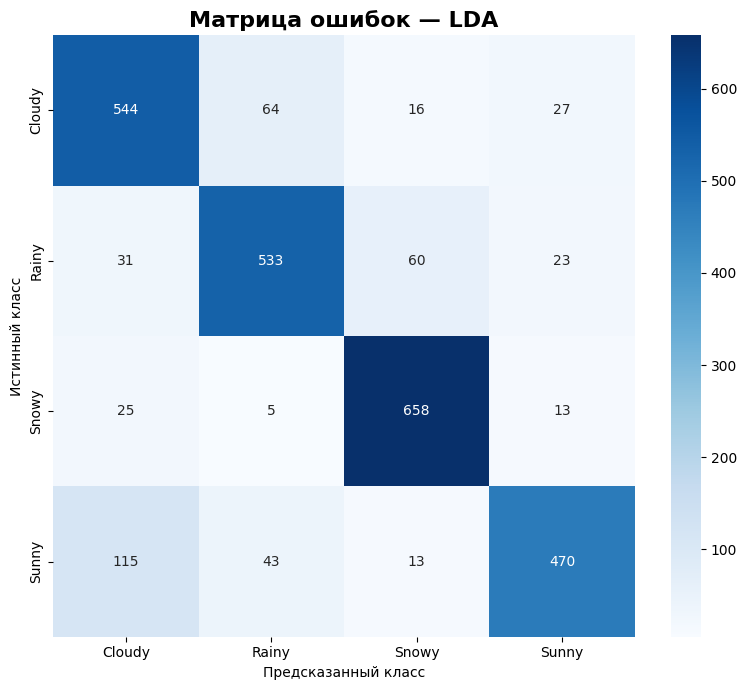

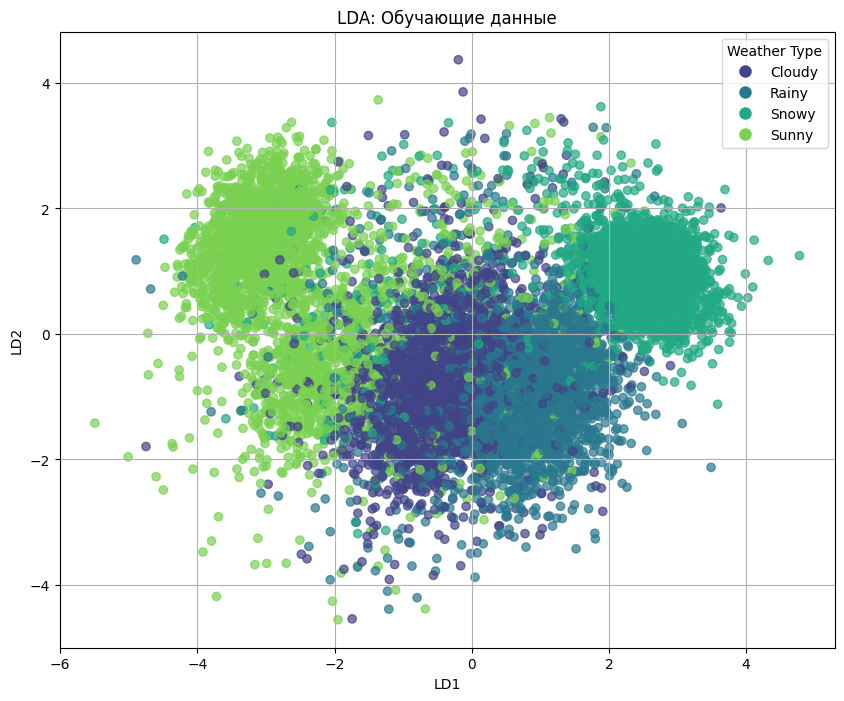

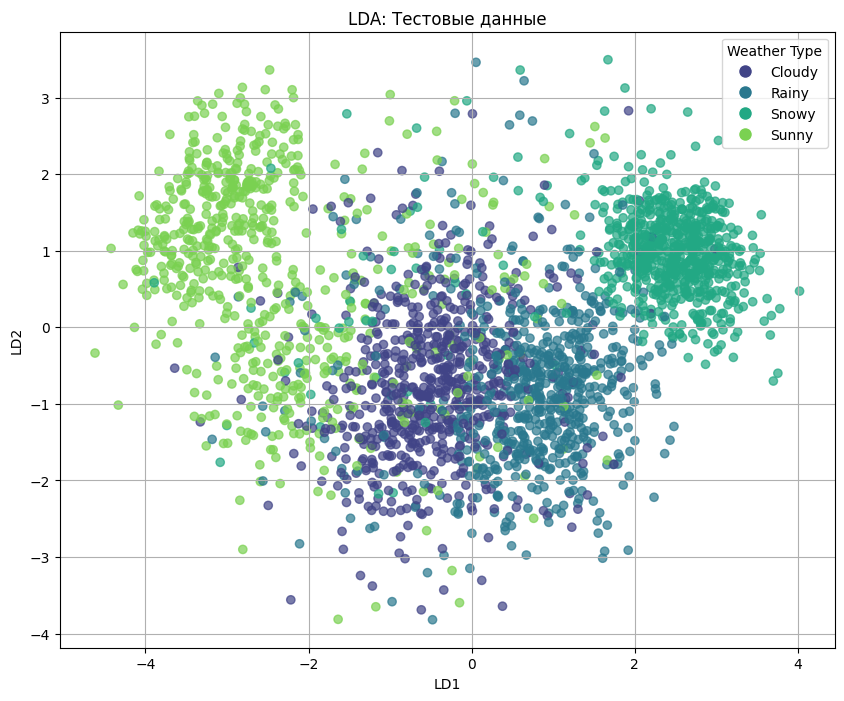

In [9]:
# Масштабируем данные
scaler = MinMaxScaler()
X_train_weather_scaled = scaler.fit_transform(X_train)
X_test_weather_scaled = scaler.transform(X_test)

# Применяем LDA
lda = LinearDiscriminantAnalysis(n_components=2)
X_train_lda = lda.fit_transform(X_train_weather_scaled, y_train)
X_test_lda = lda.transform(X_test_weather_scaled)

# Предсказания и вероятности
y_train_pred_lda = lda.predict(X_train_weather_scaled)
y_test_pred_lda = lda.predict(X_test_weather_scaled)
y_train_proba_lda = lda.predict_proba(X_train_weather_scaled)
y_test_proba_lda = lda.predict_proba(X_test_weather_scaled)

# Вычисляем метрики для обучающего множества
print("Линейный Дискриминантный Анализ (LDA)")
train_metrics = calculate_metrics(y_train, y_train_pred_lda, y_train_proba_lda, "обучающего множества")

# Вычисляем метрики для тестового множества
test_metrics = calculate_metrics(y_test, y_test_pred_lda, y_test_proba_lda, "тестового множества")

# Отчет о классификации для тестового множества
print("\nОтчет о классификации:")
print(classification_report(y_test, y_test_pred_lda))

# Матрица ошибок для тестового множества
plt.figure(figsize=(8, 7))
cm = confusion_matrix(y_test, y_test_pred_lda)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=lda.classes_, yticklabels=lda.classes_)
plt.title('Матрица ошибок — LDA', fontsize=16, fontweight='bold')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.savefig('lda_confusion_matrix.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

# Определяем порядок классов и палитру
weather_types = lda.classes_
palette = sns.color_palette("viridis", n_colors=len(weather_types))
color_map = dict(zip(weather_types, palette))

# Визуализация результатов LDA для обучающих данных
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=[color_map[cls] for cls in y_train], alpha=0.7)
plt.title('LDA: Обучающие данные')
plt.xlabel('LD1')
plt.ylabel('LD2')
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cls], markersize=10, label=cls) for cls in weather_types]
plt.legend(title='Weather Type', handles=handles)
plt.grid(True)
plt.savefig('lda_training_projection.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

# Визуализация результатов LDA для тестовых данных
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_test_lda[:, 0], X_test_lda[:, 1], c=[color_map[cls] for cls in y_test], alpha=0.7)
plt.title('LDA: Тестовые данные')
plt.xlabel('LD1')
plt.ylabel('LD2')
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cls], markersize=10, label=cls) for cls in weather_types]
plt.legend(title='Weather Type', handles=handles)
plt.grid(True)
plt.savefig('lda_test_projection.png', format='png', dpi=200, bbox_inches='tight')
plt.show()


Оси LD1 и LD2 представляют собой линейные комбинации исходных признаков, которые лучше всего разделяют классы.

На обоих графиках видно, что классы частично перекрываются, но есть области, где классы достаточно хорошо разделены. Распределение на тестовых данных похоже на обучающие данные.

LDA достаточно хорошо разделяет классы, но не идеально. Это может быть связано с природой данных, где погодные условия могут иметь схожие параметры (например, температура и влажность могут быть похожими для разных типов погоды).

Также по матрице ошибок и выводимым данным видно, что у метода есть проблемы с определением облачной и дождливой погодой: блачная погода часто путается с солнечной, а дождливую - с облачной

**Метод опорных векторов**

Мы хотим найти прямую линию (в 2D) или гиперплоскость (в многомерном пространстве), которая разделяет эти два класса.
Эта линия задаётся линейной функцией — то есть функцией вида f(x)=w⋅x+b , где:

x — вектор признаков объекта,
w — весовой вектор (нормаль к гиперплоскости),
b — смещение (bias).

Главная цель SVM как классификатора — найти уравнение разделяющей гиперплоскости w1x1 + w2x2+ wnxn+w0  в пространстве Rn, которая бы разделила два класса неким оптимальным образом. Общий вид преобразования F объекта x в метку класса Y: F(x)=sign(wTx - b), где b=-w0.

Отчет о классификации для SVM:
              precision    recall  f1-score   support

      Cloudy       0.84      0.89      0.87       651
       Rainy       0.89      0.87      0.88       647
       Snowy       0.94      0.94      0.94       701
       Sunny       0.93      0.89      0.91       641

    accuracy                           0.90      2640
   macro avg       0.90      0.90      0.90      2640
weighted avg       0.90      0.90      0.90      2640

Accuracy: 0.8992
Precision: 0.9005
Recall: 0.8992
F1-Score: 0.8996
AUC-ROC: 0.9827


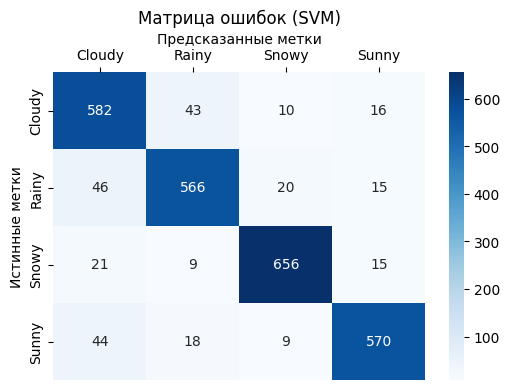

In [10]:

# Масштабируем данные
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создаем и обучаем модель SVM
svm_model = SVC(kernel='rbf', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Предсказание и вероятности классов
y_pred_svm = svm_model.predict(X_test_scaled)
y_prob_svm = svm_model.predict_proba(X_test_scaled)

# Вычисляем метрики
accuracy = accuracy_score(y_test, y_pred_svm)
precision = precision_score(y_test, y_pred_svm, average='weighted')
recall = recall_score(y_test, y_pred_svm, average='weighted')
f1 = f1_score(y_test, y_pred_svm, average='weighted')

# Для вычисления AUC-ROC необходимо бинаризовать метки классов
y_test_bin = label_binarize(y_test, classes=svm_model.classes_)
roc_auc = roc_auc_score(y_test_bin, y_prob_svm, multi_class='ovr')

# Выводим метрики
print("Отчет о классификации для SVM:")
print(classification_report(y_test, y_pred_svm))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

y_test_generic = y_test  
y_pred_generic = y_pred_svm
model_name = "SVM" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()


Метод опорных векторов продемонстрировал высокое и сбалансированное качество классификации, заметно превосходящее результаты дерева решений. Общая точность модели составляет около 90%, а значения precision, recall и F1-меры по всем классам находятся примерно на одном уровне — около 0.90. Это указывает на то, что модель одинаково хорошо справляется как с обнаружением объектов конкретного класса, так и с избеганием ложных срабатываний. Величина AUC-ROC, равная 0.9827, говорит о том, что SVM очень эффективно разделяет классы в многоклассовом пространстве признаков, что является признаком высокой обученности и качественной структуры данных.

На уровне отдельных классов наблюдается выраженное превосходство модели в распознавании snowy-состояний: и точность, и полнота этого класса достигают 0.94, что делает его наиболее чистым и предсказуемым. Это объясняется тем, что признаки снежной погоды — низкая температура, определённые сезонные параметры и плохая видимость — достаточно чётко отделяются от остальных. Солнечные дни также распознаются хорошо: модель редко ошибается, хотя иногда путает слабую облачность с солнцем. Наиболее проблемной остаётся граница между Cloudy и Rainy, что подтверждается матрицей ошибок. Значительная часть ошибок при классификации облачной погоды уходит в дождливую и наоборот, что естественно: оба состояния характеризуются схожими значениями видимости и UV-индекса. Тем не менее даже в этих классах модель показывает высокие F1-меры — около 0.87–0.88.

**Метод ближайших соседей**

Алгоритм классификации и регрессии, основанный на гипотезе компактности, которая предполагает, что расположенные близко друг к другу объекты в пространстве признаков имеют схожие значения целевой переменной или принадлежат к одному классу.
Алгоритм строится следующим образом:
1) сначала вычисляется расстояние между тестовым и всеми обучающими образцами;
2) далее из них выбирается k-ближайших образцов (соседей), где число k задаётся заранее;
3) итоговым прогнозом среди выбранных k-ближайших образцов будет мода в случае классификации и среднее арифметическое в случае регрессии;
4) предыдущие шаги повторяются для всех тестовых образцов.


Отчет о классификации для k-NN:
              precision    recall  f1-score   support

      Cloudy       0.84      0.87      0.86       651
       Rainy       0.84      0.86      0.85       647
       Snowy       0.93      0.93      0.93       701
       Sunny       0.94      0.88      0.91       641

    accuracy                           0.89      2640
   macro avg       0.89      0.89      0.89      2640
weighted avg       0.89      0.89      0.89      2640

Accuracy: 0.8871
Precision: 0.8886
Recall: 0.8871
F1-Score: 0.8875
AUC-ROC: 0.9655


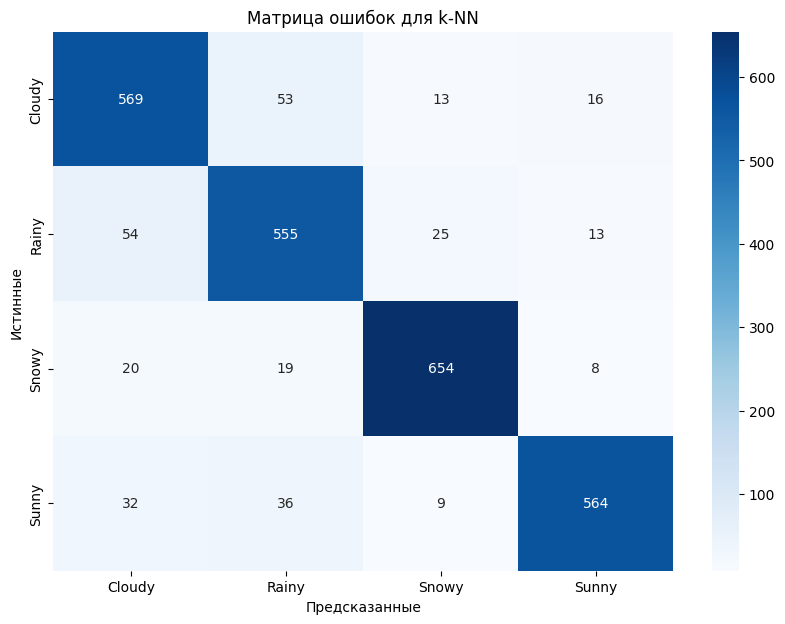

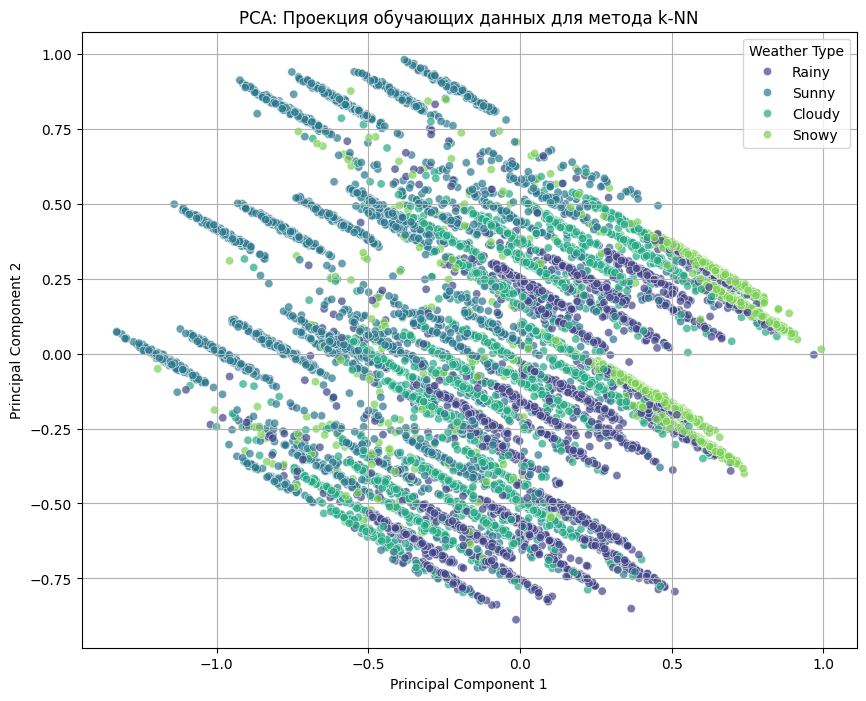

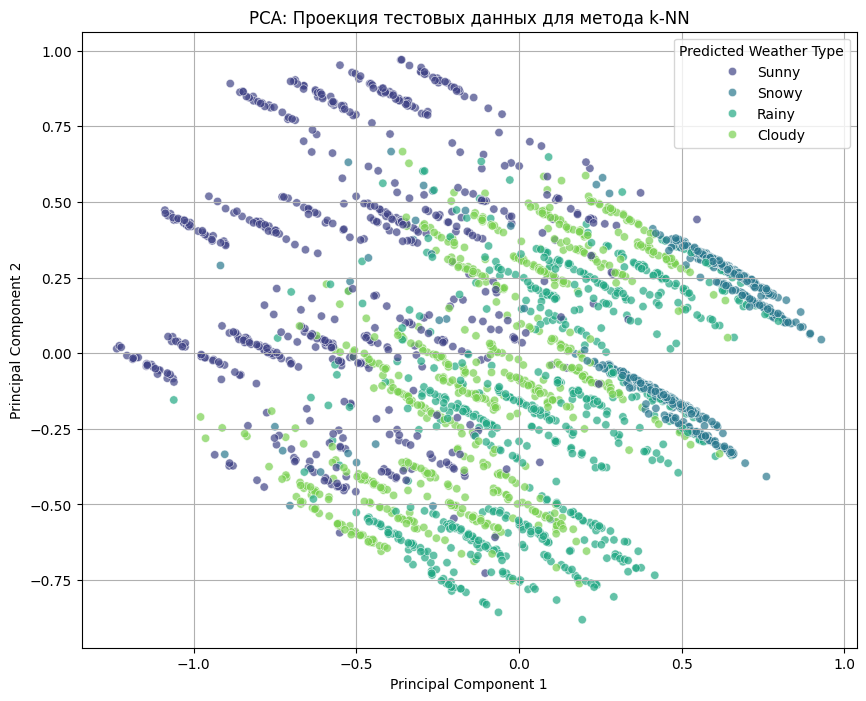

In [11]:
# Масштабируем данные
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Создаем и обучаем модель k-NN с оптимальными параметрами
knn_model = KNeighborsClassifier(n_neighbors=5, weights='uniform', metric='euclidean')
knn_model.fit(X_train_scaled, y_train)

# Предсказание и вероятности классов
y_pred_knn = knn_model.predict(X_test_scaled)
y_prob_knn = knn_model.predict_proba(X_test_scaled)

# Вычисляем метрики
accuracy = accuracy_score(y_test, y_pred_knn)
precision = precision_score(y_test, y_pred_knn, average='weighted')
recall = recall_score(y_test, y_pred_knn, average='weighted')
f1 = f1_score(y_test, y_pred_knn, average='weighted')

# Для вычисления AUC-ROC необходимо бинаризовать метки классов
y_test_bin = label_binarize(y_test, classes=knn_model.classes_)
roc_auc = roc_auc_score(y_test_bin, y_prob_knn, multi_class='ovr')

# Выводим метрики
print("Отчет о классификации для k-NN:")
print(classification_report(y_test, y_pred_knn))
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {roc_auc:.4f}")

# Матрица ошибок
conf_matrix = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=knn_model.classes_, yticklabels=knn_model.classes_)
plt.title('Матрица ошибок для k-NN')
plt.xlabel('Предсказанные')
plt.ylabel('Истинные')
plt.show()

# Уменьшаем размерность данных до 2D с помощью PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Визуализация обучающих данных
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='viridis', alpha=0.7)
plt.title('PCA: Проекция обучающих данных для метода k-NN')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Weather Type')
plt.grid(True)
plt.show()

# Визуализация предсказаний на тестовых данных
X_test_pca = pca.transform(X_test_scaled)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_pred_knn, palette='viridis', alpha=0.7)
plt.title('PCA: Проекция тестовых данных для метода k-NN')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Predicted Weather Type')
plt.grid(True)
plt.show()

На графике обучающих данных видно, что классы "Sunny" (солнечно), "Snowy" (снежно), "Rainy" (дождливо) и "Cloudy" (облачно) распределены по пространству главных компонент с определёнными закономерностями. Класс "Sunny" преимущественно сосредоточен в верхней и правой частях графика, в то время как класс "Snowy" имеет скопления в нижней и левой частях. Класс "Rainy" в основном сосредоточен в нижней части графика, а класс "Cloudy" распределён более равномерно, но с некоторыми скоплениями в центральной и правой частях. Однако существует значительное перекрытие между классами, особенно между "Sunny", "Cloudy" и "Snowy". Это может свидетельствовать о сложности задачи классификации и необходимости использования более сложных моделей или дополнительных признаков для улучшения разделения классов.

На графике тестовых данных точки окрашены в соответствии с предсказанными классами методом k-NN. Распределение предсказанных классов "Sunny" и "Snowy" также охватывает всё пространство главных компонент, но с определёнными скоплениями в некоторых областях. Предсказанные классы "Rainy" и "Cloudy" имеют схожее распределение с обучающими данными, но с меньшей плотностью точек. Однако можно заметить ошибки классификации, особенно в областях перекрытия классов на графике обучающих данных. Например, в областях, где классы "Sunny" и "Cloudy" перекрываются, на графике тестовых данных некоторые точки "Sunny" предсказаны как "Cloudy" и наоборот.
Таким образом, метод k-NN показывает разумные результаты, но с заметными ошибками в областях перекрытия классов. Это может быть связано с недостаточной разделительной способностью признаков в пространстве главных компонент.


**2. Сравнение метрик**

Метрики для GaussianNB:

Accuracy: 0.8367<br>Precision: 0.8379<br>Recall: 0.8367<br>F1-Score: 0.8351<br>ROC AUC: 0.9446


Метрики для MultinomialNB:

Accuracy: 0.7053
<br>Precision: 0.6947
<br>Recall: 0.7053
<br>F1-Score: 0.6926
<br>ROC AUC: 0.8938


Метрики для ComplementNB:

Accuracy: 0.6394
<br>Precision: 0.6440
<br>Recall: 0.6394
<br>F1-Score: 0.6150
<br>ROC AUC: 0.8680


Метрики для BernoulliNB:

Accuracy: 0.6443
<br>Precision: 0.6658
<br>Recall: 0.6443
<br>F1-Score: 0.6452
<br>ROC AUC: 0.8373


Метрики для Дерева решений:

Accuracy: 0.9064
<br>Precision: 0.9066
<br>Recall: 0.9064
<br>F1-Score: 0.9064
<br>ROC AUC: 0.9653

Метрики для линейного дискриминантного анализа

<br>Accuracy: 0.8352
<br>Precision: 0.8381
<br>Recall: 0.8352
<br>F1-Score: 0.8343
<br>AUC-ROC: 0.9463

Метрики для метода опорных векторов

<br>Accuracy: 0.8992
<br>Precision: 0.9005
<br>Recall: 0.8992
<br>F1-Score: 0.8996
<br>AUC-ROC: 0.9827

Метрики для метода ближайших соседей:

<br>Accuracy: 0.8871
<br>Precision: 0.8886
<br>Recall: 0.8871
<br>F1-Score: 0.8875
<br>AUC-ROC: 0.9655

По абсолютно всем метрикам наименьшие значения имеют методы наивного Байесовского алгоритма, а наибольшие, за искоючением величины AUC-ROC - Дерево решений. Значение для AUC-ROC наибольшее у метода опорных векторов.

**3. Настройка гиперпараметров**

**Наивный Байесовский классификатор**

Fitting 5 folds for each of 100 candidates, totalling 500 fits
Наивный Байесовский классификатор (GaussianNB)
Метрики для обучающего множества:
Accuracy: 0.8611
Precision: 0.8618
Recall: 0.8611
F1-Score: 0.8609
ROC AUC: 0.9528


Метрики для тестового множества:
Accuracy: 0.8629
Precision: 0.8638
Recall: 0.8629
F1-Score: 0.8627
ROC AUC: 0.9536



Отчет о классификации:
              precision    recall  f1-score   support

      Cloudy     0.8767    0.7972    0.8351       651
       Rainy     0.8323    0.8439    0.8381       647
       Snowy     0.9254    0.9372    0.9313       701
       Sunny     0.8152    0.8674    0.8405       641

    accuracy                         0.8629      2640
   macro avg     0.8624    0.8614    0.8612      2640
weighted avg     0.8638    0.8629    0.8627      2640



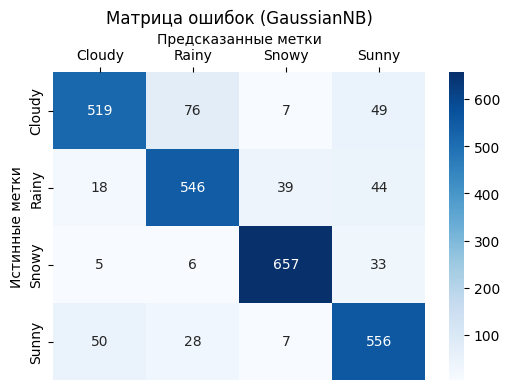

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Наивный Байесовский классификатор (MultinomialNB)
Метрики для обучающего множества:
Accuracy: 0.7841
Precision: 0.7877
Recall: 0.7841
F1-Score: 0.7835
ROC AUC: 0.9132


Метрики для тестового множества:
Accuracy: 0.7886
Precision: 0.7901
Recall: 0.7886
F1-Score: 0.7873
ROC AUC: 0.9148



Отчет о классификации:
              precision    recall  f1-score   support

      Cloudy     0.7532    0.8111    0.7811       651
       Rainy     0.7765    0.7249    0.7498       647
       Snowy     0.8003    0.8916    0.8435       701
       Sunny     0.8303    0.7176    0.7699       641

    accuracy                         0.7886      2640
   macro avg     0.7901    0.7863    0.7860      2640
weighted avg     0.7901    0.7886    0.7873      2640



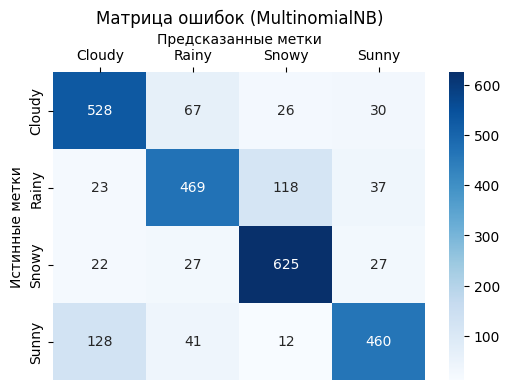

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Наивный Байесовский классификатор (ComplementNB)
Метрики для обучающего множества:
Accuracy: 0.6988
Precision: 0.7560
Recall: 0.6988
F1-Score: 0.6863
ROC AUC: 0.8979


Метрики для тестового множества:
Accuracy: 0.7053
Precision: 0.7595
Recall: 0.7053
F1-Score: 0.6919
ROC AUC: 0.8990



Отчет о классификации:
              precision    recall  f1-score   support

      Cloudy     0.9434    0.4608    0.6192       651
       Rainy     0.8208    0.5240    0.6396       647
       Snowy     0.6432    0.9001    0.7503       701
       Sunny     0.6379    0.9236    0.7546       641

    accuracy                         0.7053      2640
   macro avg     0.7613    0.7021    0.6909      2640
weighted avg     0.7595    0.7053    0.6919      2640



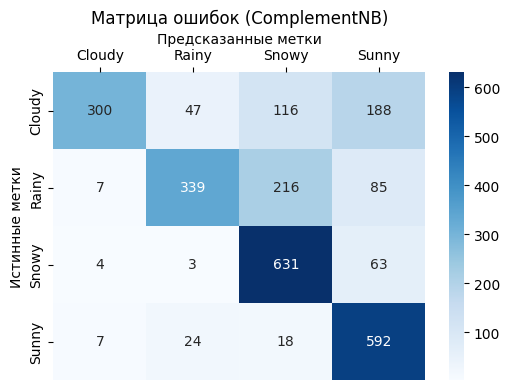

Fitting 5 folds for each of 20 candidates, totalling 100 fits

Наивный Байесовский классификатор (BernoulliNB)
Метрики для обучающего множества:
Accuracy: 0.6302
Precision: 0.7864
Recall: 0.6302
F1-Score: 0.5956
ROC AUC: 0.8431


Метрики для тестового множества:
Accuracy: 0.6356
Precision: 0.7781
Recall: 0.6356
F1-Score: 0.6003
ROC AUC: 0.8437



Отчет о классификации:
              precision    recall  f1-score   support

      Cloudy     0.4299    0.9616    0.5942       651
       Rainy     0.8590    0.1036    0.1848       647
       Snowy     0.8239    0.8074    0.8156       701
       Sunny     1.0000    0.6537    0.7906       641

    accuracy                         0.6356      2640
   macro avg     0.7782    0.6316    0.5963      2640
weighted avg     0.7781    0.6356    0.6003      2640



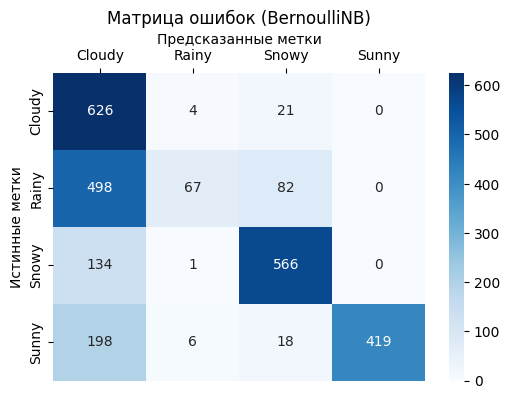

In [12]:

results = []

# GaussianNB
param_grid_gaussian = {'var_smoothing': np.logspace(0, -9, num=100)}
grid_gaussian = GridSearchCV(GaussianNB(), param_grid_gaussian, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_gaussian.fit(X_train, y_train)

y_train_pred_gaussian = grid_gaussian.predict(X_train)
y_test_pred_gaussian = grid_gaussian.predict(X_test)
y_train_proba_gaussian = grid_gaussian.predict_proba(X_train)
y_test_proba_gaussian = grid_gaussian.predict_proba(X_test)

print("Наивный Байесовский классификатор (GaussianNB)")
results.append({
    'Model': 'GaussianNB (best)',
    'Dataset': 'Train',
    **calculate_metrics(y_train, y_train_pred_gaussian, y_train_proba_gaussian, "обучающего множества")
})

results.append({
    'Model': 'GaussianNB (best)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_gaussian, y_test_proba_gaussian, "тестового множества")
})

print("\nОтчет о классификации:")
print(classification_report(y_test, y_test_pred_gaussian, digits=4))

# Матрица ошибок
cm = confusion_matrix(y_test, y_test_pred_gaussian)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=0)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок (GaussianNB)')
plt.show()

# MultinomialNB
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
param_grid_multinomial = {'alpha': np.linspace(0.1, 2, 20)}
grid_multinomial = GridSearchCV(MultinomialNB(), param_grid_multinomial, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_multinomial.fit(X_train_scaled, y_train)

y_train_pred_multinomial = grid_multinomial.predict(X_train_scaled)
y_test_pred_multinomial = grid_multinomial.predict(X_test_scaled)
y_train_proba_multinomial = grid_multinomial.predict_proba(X_train_scaled)
y_test_proba_multinomial = grid_multinomial.predict_proba(X_test_scaled)

print("\nНаивный Байесовский классификатор (MultinomialNB)")
results.append({
    'Model': 'MultinomialNB (best)',
    'Dataset': 'Train',
    **calculate_metrics(y_train, y_train_pred_multinomial, y_train_proba_multinomial, "обучающего множества")
})

results.append({
    'Model': 'MultinomialNB (best)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_multinomial, y_test_proba_multinomial, "тестового множества")
})

print("\nОтчет о классификации:")
print(classification_report(y_test, y_test_pred_multinomial, digits=4))

# Матрица ошибок
cm = confusion_matrix(y_test, y_test_pred_multinomial)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=0)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок (MultinomialNB)')
plt.show()

# ComplementNB
param_grid_complement = {'alpha': np.linspace(0.1, 2, 20)}
grid_complement = GridSearchCV(ComplementNB(), param_grid_complement, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_complement.fit(X_train_scaled, y_train)

y_train_pred_complement = grid_complement.predict(X_train_scaled)
y_test_pred_complement = grid_complement.predict(X_test_scaled)
y_train_proba_complement = grid_complement.predict_proba(X_train_scaled)
y_test_proba_complement = grid_complement.predict_proba(X_test_scaled)

print("\nНаивный Байесовский классификатор (ComplementNB)")
results.append({
    'Model': 'ComplementNB (best)',
    'Dataset': 'Train',
    **calculate_metrics(y_train, y_train_pred_complement, y_train_proba_complement, "обучающего множества")
})

results.append({
    'Model': 'ComplementNB (best)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_complement, y_test_proba_complement, "тестового множества")
})

print("\nОтчет о классификации:")
print(classification_report(y_test, y_test_pred_complement, digits=4))

# Матрица ошибок
cm = confusion_matrix(y_test, y_test_pred_complement)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=0)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок (ComplementNB)')
plt.show()

# BernoulliNB
param_grid_bernoulli = {'alpha': np.linspace(0.1, 2, 20)}
grid_bernoulli = GridSearchCV(BernoulliNB(), param_grid_bernoulli, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_bernoulli.fit(X_train, y_train)

y_train_pred_bernoulli = grid_bernoulli.predict(X_train)
y_test_pred_bernoulli = grid_bernoulli.predict(X_test)
y_train_proba_bernoulli = grid_bernoulli.predict_proba(X_train)
y_test_proba_bernoulli = grid_bernoulli.predict_proba(X_test)

print("\nНаивный Байесовский классификатор (BernoulliNB)")
results.append({
    'Model': 'BernoulliNB (best)',
    'Dataset': 'Train',
    **calculate_metrics(y_train, y_train_pred_bernoulli, y_train_proba_bernoulli, "обучающего множества")
})

results.append({
    'Model': 'BernoulliNB (best)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_bernoulli, y_test_proba_bernoulli, "тестового множества")
})

print("\nОтчет о классификации:")
print(classification_report(y_test, y_test_pred_bernoulli, digits=4))

# Матрица ошибок
cm = confusion_matrix(y_test, y_test_pred_bernoulli)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xticks(rotation=0)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок (BernoulliNB)')
plt.show()


Сравнивая с изначальными данными, можно увидеть, что после настройки гиперпараметров основные метрики увеличились для всех метода Байесовского классификатораю. Метод BernoulliNB слишком часто путает дождливую погоду с облачной, а ComplementNB все также имеет некоторые проблемы с классификацией и облачной, и дождливой погодой

**Дерево решений**

Fitting 5 folds for each of 72 candidates, totalling 360 fits


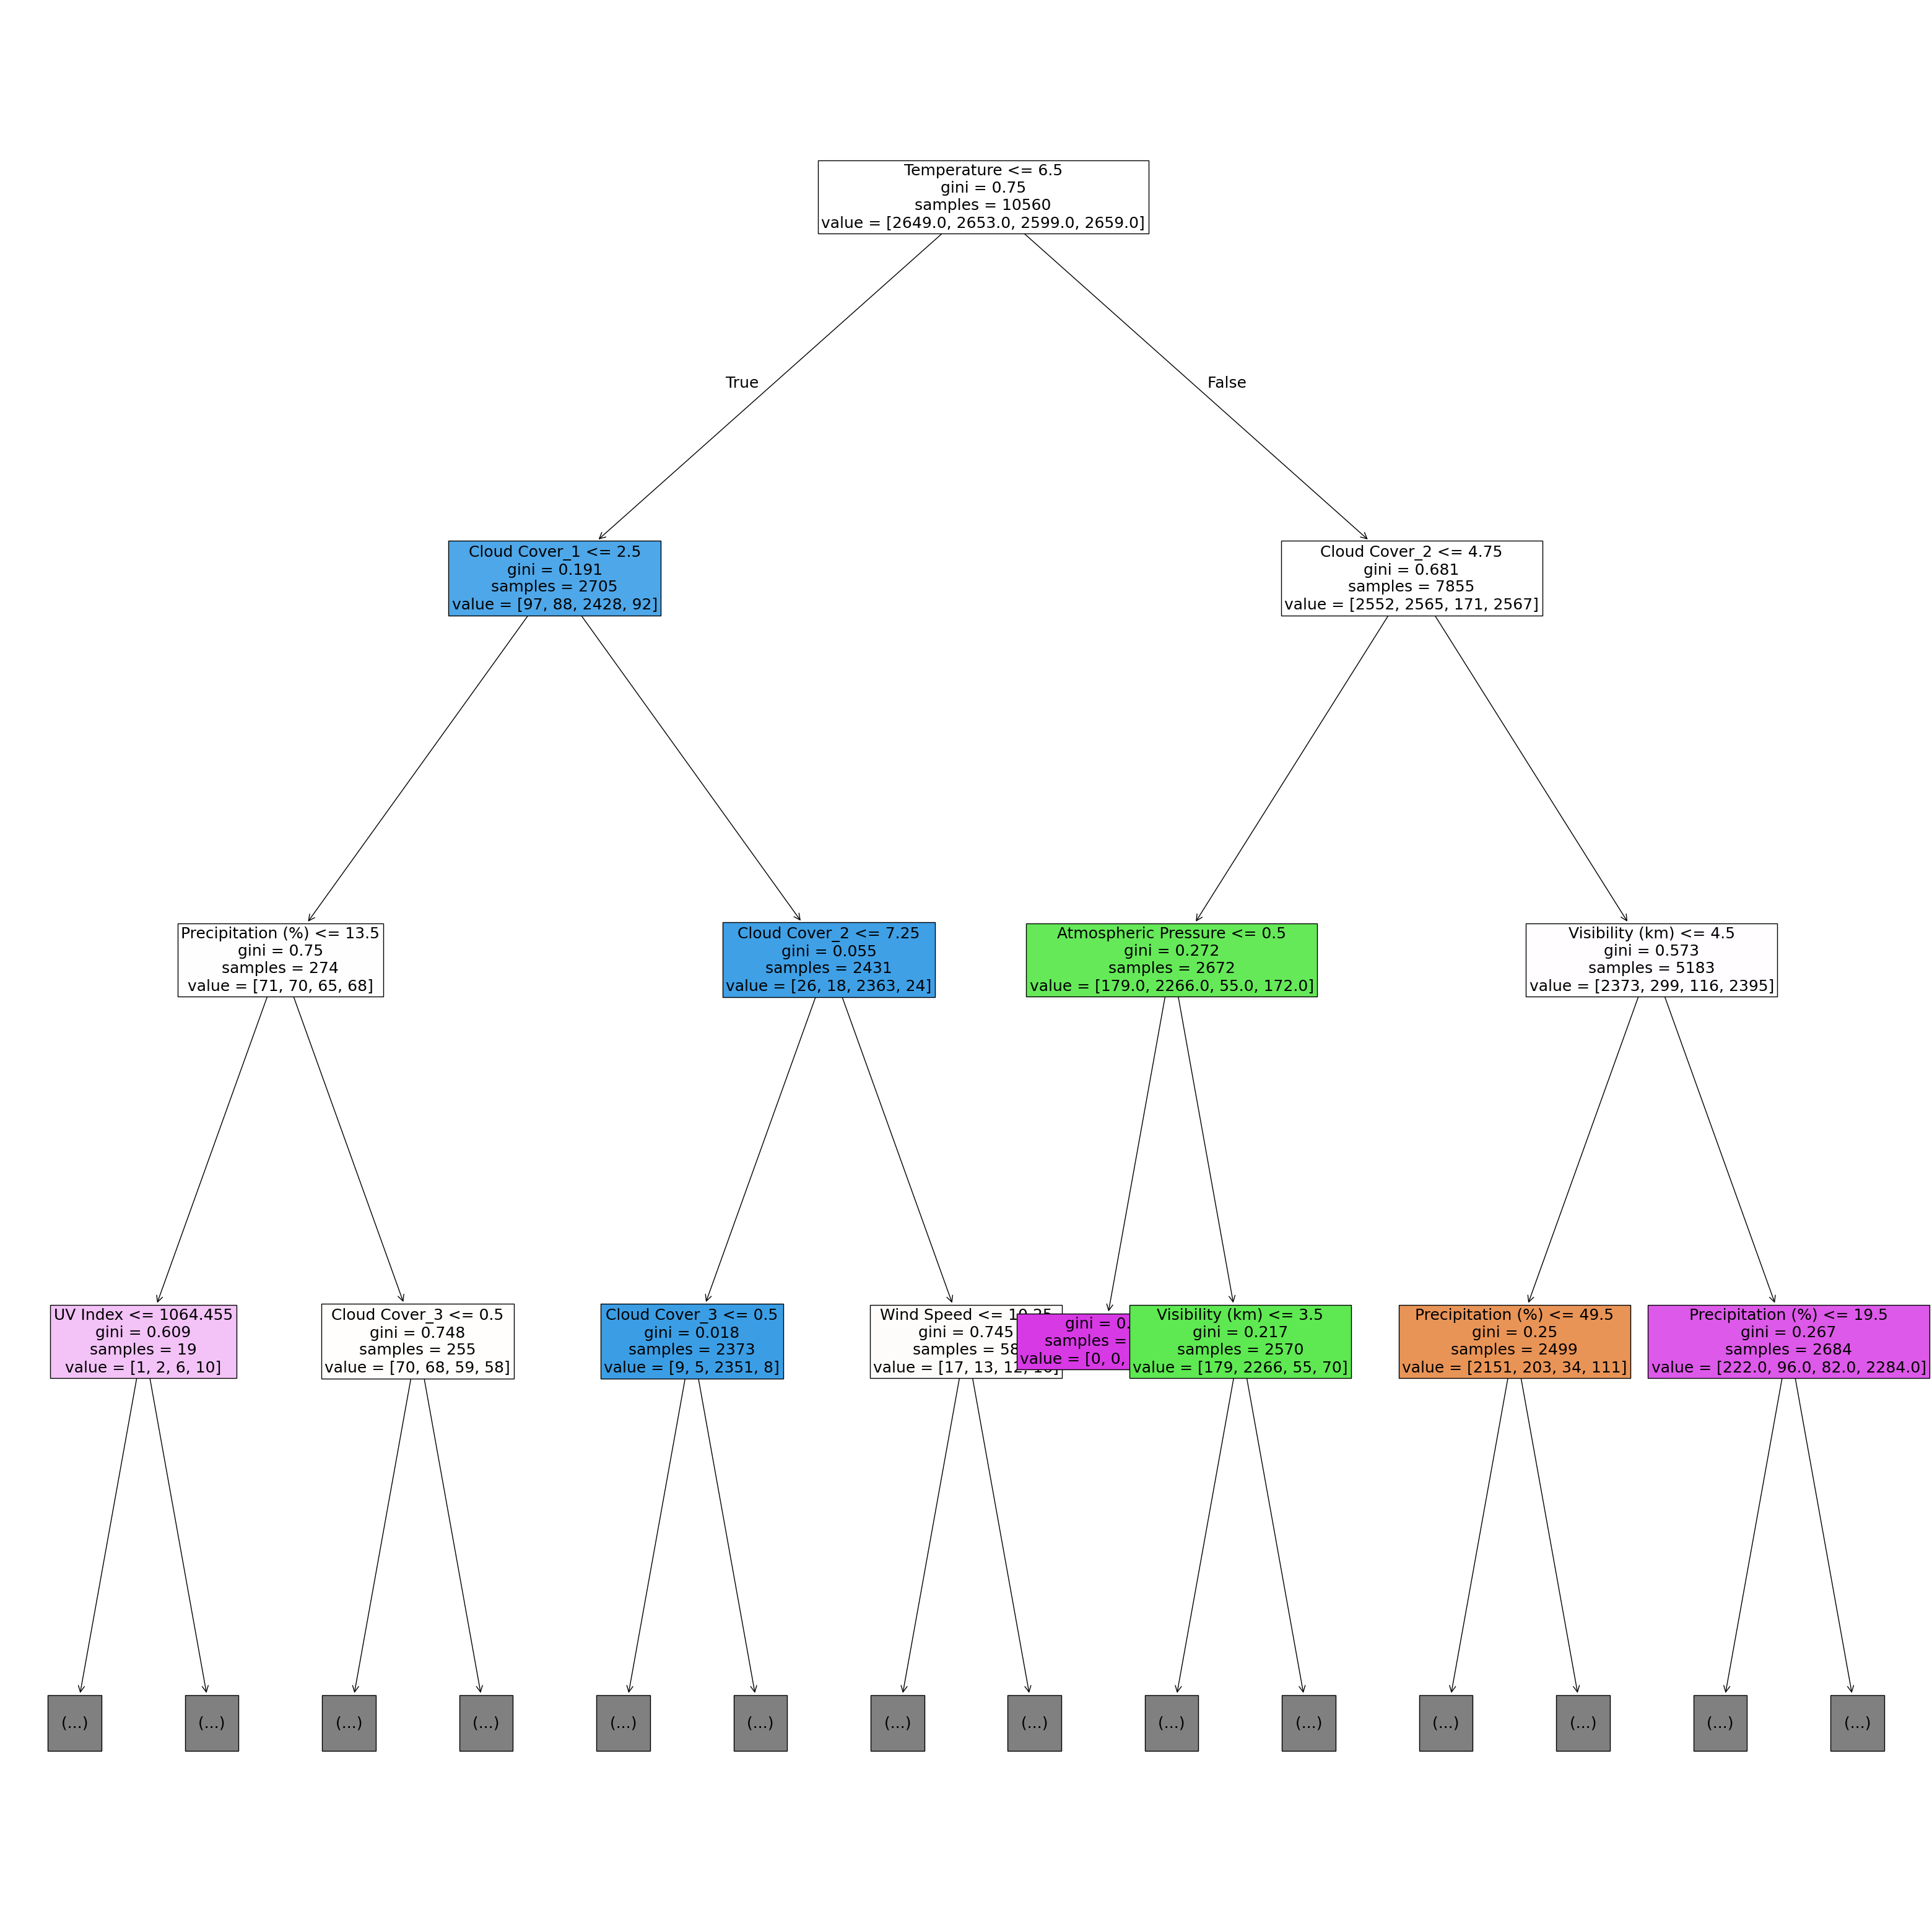

Дерево решений (best)
Метрики для обучающего множества:
Accuracy: 0.9483
Precision: 0.9496
Recall: 0.9483
F1-Score: 0.9485
ROC AUC: 0.9974


Метрики для тестового множества:
Accuracy: 0.9133
Precision: 0.9150
Recall: 0.9133
F1-Score: 0.9136
ROC AUC: 0.9757



Отчет о классификации:
              precision    recall  f1-score   support

      Cloudy     0.8820    0.8955    0.8887       651
       Rainy     0.8675    0.9212    0.8936       647
       Snowy     0.9456    0.9415    0.9435       701
       Sunny     0.9630    0.8924    0.9263       641

    accuracy                         0.9133      2640
   macro avg     0.9145    0.9126    0.9130      2640
weighted avg     0.9150    0.9133    0.9136      2640



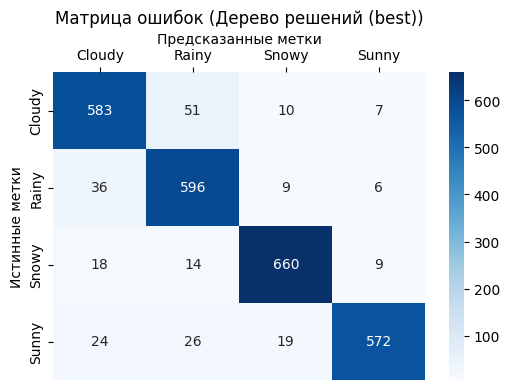

In [13]:
param_grid = {
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']
}

# Создание модели
dt_classifier = DecisionTreeClassifier(random_state=42)

grid_dt = GridSearchCV(dt_classifier, param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_dt.fit(X_train, y_train)

# Предсказания
y_train_pred_dt_best = grid_dt.predict(X_train)
y_test_pred_dt_best = grid_dt.predict(X_test)
y_train_proba_dt_best = grid_dt.predict_proba(X_train)
y_test_proba_dt_best = grid_dt.predict_proba(X_test)

# Лучшая модель
best_dt = grid_dt.best_estimator_

# Визуализация дерева
plt.figure(figsize=(40, 40))
plot_tree(best_dt, filled=True, max_depth=3, fontsize=18, feature_names=feature_names)
plt.show()

print("Дерево решений (best)")

results = []

# Метрики для обучающего множества
results.append({
    'Model': 'Дерево решений (best)',
    'Dataset': 'Train',
    **calculate_metrics(y_train, y_train_pred_dt_best, y_train_proba_dt_best, "обучающего множества")
})

# Метрики для тестового множества
results.append({
    'Model': 'Дерево решений (best)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_dt_best, y_test_proba_dt_best, "тестового множества")
})

# Отчет о классификации
print("\nОтчет о классификации:")
print(classification_report(y_test, y_test_pred_dt_best, digits=4))

# Матрица ошибок
y_test_generic = y_test
y_pred_generic = y_test_pred_dt_best
model_name = "Дерево решений (best)"
label_encoder = le  # Убедитесь, что le определен как ваш LabelEncoder

cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

Коэффициенты Джини в дереве не поменялись, при этом качество всех метрик повысилось

**Дискриминантный анализ**

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Линейный Дискриминантный Анализ (LDA)
Метрики для обучающего множества:
Accuracy: 0.8371
Precision: 0.8408
Recall: 0.8371
F1-Score: 0.8367
ROC AUC: 0.9463


Метрики для тестового множества:
Accuracy: 0.8352
Precision: 0.8381
Recall: 0.8352
F1-Score: 0.8343
ROC AUC: 0.9463



Отчет о классификации:
              precision    recall  f1-score   support

      Cloudy     0.7608    0.8356    0.7965       651
       Rainy     0.8264    0.8238    0.8251       647
       Snowy     0.8809    0.9387    0.9088       701
       Sunny     0.8818    0.7332    0.8007       641

    accuracy                         0.8352      2640
   macro avg     0.8375    0.8328    0.8328      2640
weighted avg     0.8381    0.8352    0.8343      2640



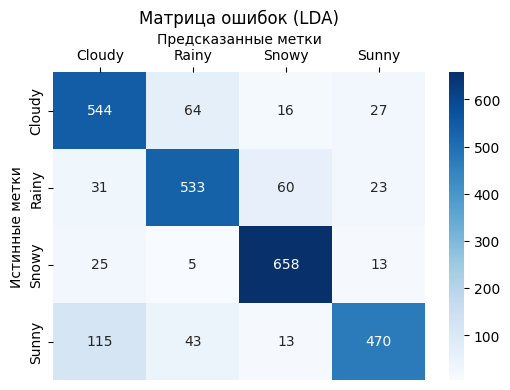

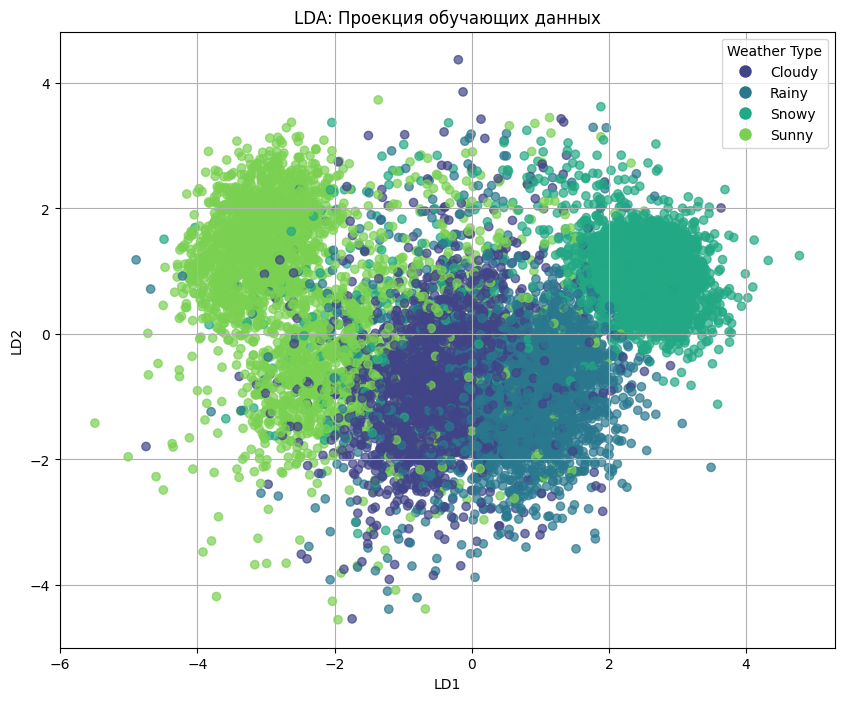

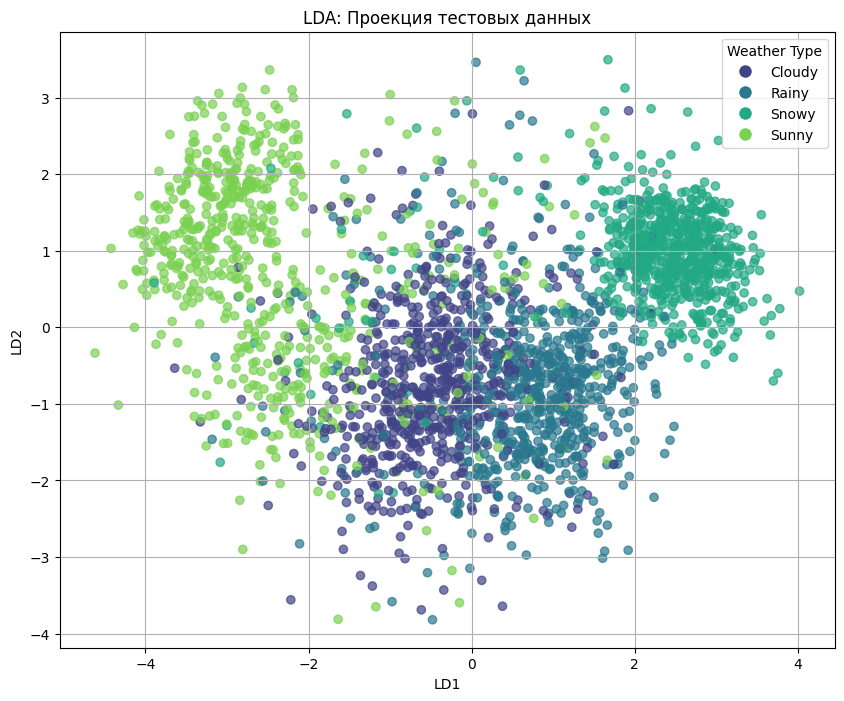

In [14]:

# Масштабируем данные
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Определение сетки параметров для LDA
param_grid_lda = {
    'solver': ['svd', 'lsqr', 'eigen'],
    'n_components': [None, 2, 3]
}

# Создание модели LDA
lda = LinearDiscriminantAnalysis()

# Поиск по сетке
grid_lda = GridSearchCV(lda, param_grid_lda, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_lda.fit(X_train_scaled, y_train)

# Лучшая модель
best_lda = grid_lda.best_estimator_

# Предсказания
y_train_pred_lda = best_lda.predict(X_train_scaled)
y_test_pred_lda = best_lda.predict(X_test_scaled)
y_train_proba_lda = best_lda.predict_proba(X_train_scaled)
y_test_proba_lda = best_lda.predict_proba(X_test_scaled)

results = []

# Метрики для обучающего множества
print("Линейный Дискриминантный Анализ (LDA)")
results.append({
    'Model': 'LDA (best)',
    'Dataset': 'Train',
    **calculate_metrics(y_train, y_train_pred_lda, y_train_proba_lda, "обучающего множества")
})

# Метрики для тестового множества
results.append({
    'Model': 'LDA (best)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_lda, y_test_proba_lda, "тестового множества")
})

# Отчет о классификации
print("\nОтчет о классификации:")
print(classification_report(y_test, y_test_pred_lda, digits=4))

# Матрица ошибок
cm = confusion_matrix(y_test, y_test_pred_lda)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=weather_types, yticklabels=weather_types)
plt.xticks(rotation=0)
plt.gca().xaxis.tick_top()
plt.gca().xaxis.set_label_position('top')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title('Матрица ошибок (LDA)')
plt.show()

# Визуализация результатов LDA для обучающих данных
X_train_lda = best_lda.transform(X_train_scaled)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_train_lda[:, 0], X_train_lda[:, 1], c=y_train.map(color_map), alpha=0.7)
plt.title('LDA: Проекция обучающих данных')
plt.xlabel('LD1')
plt.ylabel('LD2')
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cls], markersize=10, label=cls) for cls in weather_types]
plt.legend(title='Weather Type', handles=handles)
plt.grid(True)
plt.savefig('lda_training_projection.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

# Визуализация результатов LDA для тестовых данных
X_test_lda = best_lda.transform(X_test_scaled)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(X_test_lda[:, 0], X_test_lda[:, 1], c=y_test.map(color_map), alpha=0.7)
plt.title('LDA: Проекция тестовых данных')
plt.xlabel('LD1')
plt.ylabel('LD2')
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color_map[cls], markersize=10, label=cls) for cls in weather_types]
plt.legend(title='Weather Type', handles=handles)
plt.grid(True)
plt.savefig('lda_test_projection.png', format='png', dpi=200, bbox_inches='tight')
plt.show()

Классы разделены более четко на графике, при этом качество метрик почти не изменилось

**Метод опорных векторов**

SVM
Метрики для обучающего множества:
Accuracy: 0.9420
Precision: 0.9423
Recall: 0.9420
F1-Score: 0.9421
ROC AUC: 0.9950


Метрики для тестового множества:
Accuracy: 0.9068
Precision: 0.9070
Recall: 0.9068
F1-Score: 0.9069
ROC AUC: 0.9865



Отчет о классификации:
              precision    recall  f1-score   support

      Cloudy     0.8744    0.8879    0.8811       651
       Rainy     0.8955    0.9011    0.8983       647
       Snowy     0.9442    0.9415    0.9429       701
       Sunny     0.9110    0.8939    0.9024       641

    accuracy                         0.9068      2640
   macro avg     0.9063    0.9061    0.9062      2640
weighted avg     0.9070    0.9068    0.9069      2640



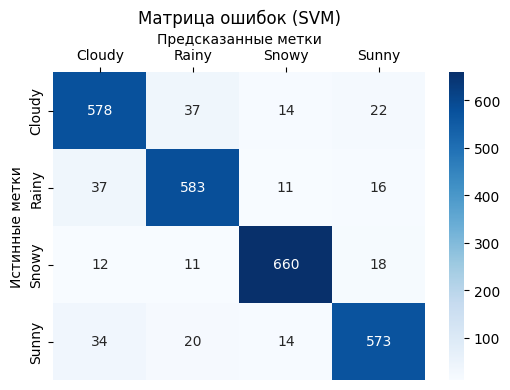

In [15]:
svm_pipe_default = Pipeline([
    ('scaler', StandardScaler()),
    ('svm', SVC(random_state=42, probability=True))
])

svm_pipe_default.fit(X_train, y_train)

y_train_pred_svm_default = svm_pipe_default.predict(X_train)
y_test_pred_svm_default = svm_pipe_default.predict(X_test)
y_train_proba_svm_default = svm_pipe_default.predict_proba(X_train)
y_test_proba_svm_default = svm_pipe_default.predict_proba(X_test)

print("SVM")
calculate_metrics(y_train, y_train_pred_svm_default, y_train_proba_svm_default, "обучающего множества")

results.append({
    'Model': 'SVM (default)',
    'Dataset': 'Test',
    **calculate_metrics(y_test, y_test_pred_svm_default, y_test_proba_svm_default, "тестового множества")

})

print("\nОтчет о классификации:")
print(classification_report(y_test, y_test_pred_svm_default, digits=4))

y_test_generic = y_test  
y_pred_generic = y_test_pred_svm_default 
model_name = "SVM" 
label_encoder = le
cm = confusion_matrix(y_test_generic, y_pred_generic)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xticks(rotation=0)  
plt.gca().xaxis.tick_top() 
plt.gca().xaxis.set_label_position('top') 
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')
plt.title(f'Матрица ошибок ({model_name})')
plt.show()

Качкстов метрик почти не изменилось

**Метод блиижайших соседей**

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Метод ближайших соседей (k-NN)
Метрики для обучающего множества:
Accuracy: 0.9203
Precision: 0.9214
Recall: 0.9203
F1-Score: 0.9206
AUC-ROC: 0.9946
Метрики для тестового множества:
Accuracy: 0.8875
Precision: 0.8891
Recall: 0.8875
F1-Score: 0.8879
AUC-ROC: 0.9669

Отчет о классификации:
              precision    recall  f1-score   support

      Cloudy     0.8346    0.8756    0.8546       651
       Rainy     0.8532    0.8624    0.8578       647
       Snowy     0.9250    0.9330    0.9290       701
       Sunny     0.9413    0.8752    0.9070       641

    accuracy                         0.8875      2640
   macro avg     0.8885    0.8865    0.8871      2640
weighted avg     0.8891    0.8875    0.8879      2640


Лучшие параметры: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'uniform'}


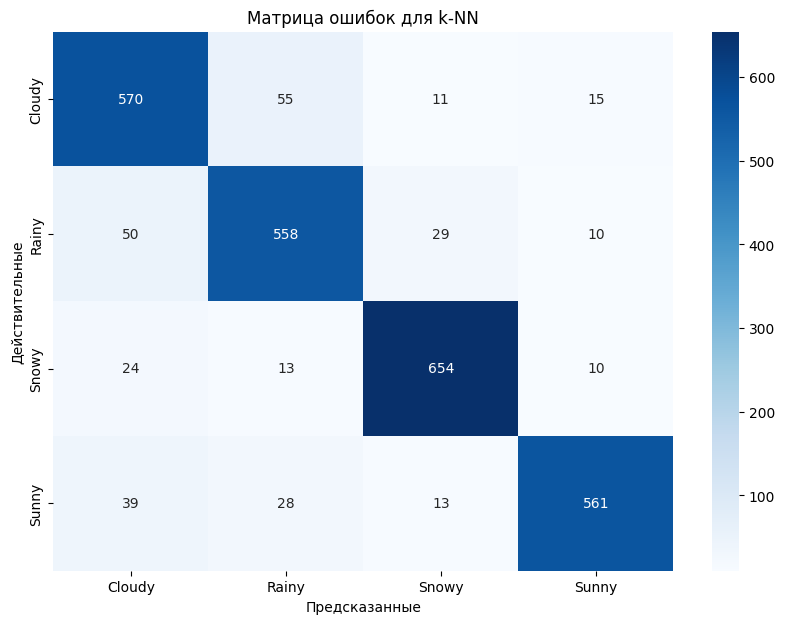

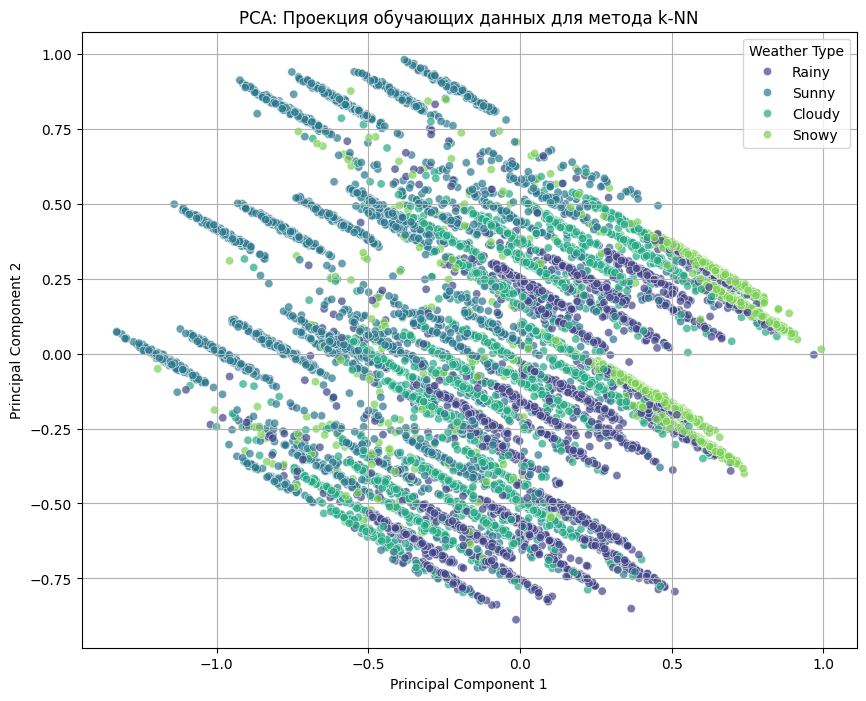

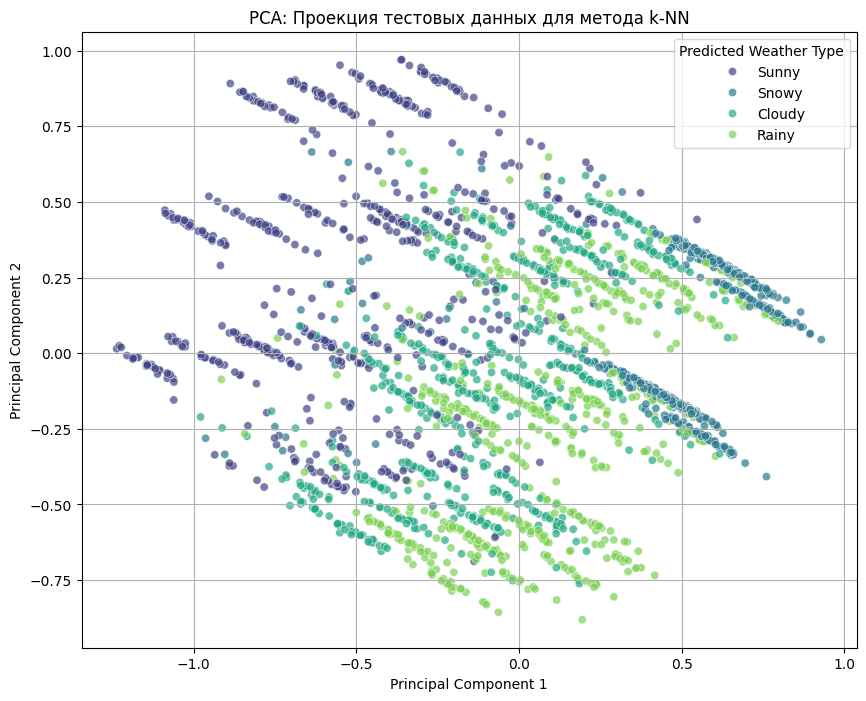

In [16]:
# Масштабируем данные
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Определение сетки параметров для k-NN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Создание модели k-NN
knn_model = KNeighborsClassifier()

# Поиск по сетке
grid_knn = GridSearchCV(knn_model, param_grid_knn, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid_knn.fit(X_train_scaled, y_train)

# Лучшая модель
best_knn = grid_knn.best_estimator_

# Предсказания
y_train_pred_knn = best_knn.predict(X_train_scaled)
y_test_pred_knn = best_knn.predict(X_test_scaled)
y_train_proba_knn = best_knn.predict_proba(X_train_scaled)
y_test_proba_knn = best_knn.predict_proba(X_test_scaled)

# Функция для вычисления метрик
def calculate_metrics(y_true, y_pred, y_proba, dataset_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    y_true_bin = label_binarize(y_true, classes=best_knn.classes_)
    roc_auc = roc_auc_score(y_true_bin, y_proba, multi_class='ovr')

    print(f"Метрики для {dataset_name}:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {roc_auc:.4f}")

    return {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1-Score': f1, 'AUC-ROC': roc_auc}

# Метрики для обучающего множества
print("Метод ближайших соседей (k-NN)")
calculate_metrics(y_train, y_train_pred_knn, y_train_proba_knn, "обучающего множества")

# Метрики для тестового множества
calculate_metrics(y_test, y_test_pred_knn, y_test_proba_knn, "тестового множества")

# Отчет о классификации
print("\nОтчет о классификации:")
print(classification_report(y_test, y_test_pred_knn, digits=4))

# Лучшие параметры
print(f"\nЛучшие параметры: {grid_knn.best_params_}")

# Матрица ошибок
plt.figure(figsize=(10, 7))
conf_matrix = confusion_matrix(y_test, y_test_pred_knn)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=best_knn.classes_, yticklabels=best_knn.classes_)
plt.title('Матрица ошибок для k-NN')
plt.xlabel('Предсказанные')
plt.ylabel('Действительные')
plt.show()

# Уменьшаем размерность данных до 2D с помощью PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Визуализация обучающих данных
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=y_train, palette='viridis', alpha=0.7)
plt.title('PCA: Проекция обучающих данных для метода k-NN')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Weather Type')
plt.grid(True)
plt.show()

# Визуализация предсказаний на тестовых данных
X_test_pca = pca.transform(X_test_scaled)
plt.figure(figsize=(10, 8))
sns.scatterplot(x=X_test_pca[:, 0], y=X_test_pca[:, 1], hue=y_test_pred_knn, palette='viridis', alpha=0.7)
plt.title('PCA: Проекция тестовых данных для метода k-NN')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Predicted Weather Type')
plt.grid(True)
plt.show()

Качество метрик улучшилось, при этом распределение на графиках до сих пор имеет перекрытие классов, пусть и классы разделены чуть более четко